<h2>Notebook for plotting performance of neural networks trained with density-based weighting at predicting storm surge extremes</h2>
Plots figures for the manuscript "Computing Extreme Storm Surges in Europe Using Neural Networks" (Hermans et al., in preparation)

In [1]:
import sys
sys.path.append("..")

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
import os
from surgeNN import io
from surgeNN.evaluation import rmse
from scipy.stats import rankdata
import gcsfs
import fnmatch
fs = gcsfs.GCSFileSystem() #list stores, stripp zarr from filename, load 

In [2]:
#configure the script
tgs        = ['stavanger-svg-nor-nhs.csv','wick-wic-gbr-bodc.csv','esbjerg-esb-dnk-dmi.csv','immingham-imm-gbr-bodc.csv','den_helder-denhdr-nld-rws.csv', 'fishguard-fis-gbr-bodc.csv',  'brest-822a-fra-uhslc.csv', 'vigo-vigo-esp-ieo.csv',  'alicante_i_outer_harbour-alio-esp-da_mm.csv']
tgnames = ['Stavanger (NOR)','Wick (UK)', 'Esbjerg (DK)','Immingham (UK)','Den Helder (NL)','Fishguard (UK)','Brest (FR)','Vigo (PT)', 'Alicante (SP)']

qnts = np.array([.95,.98,.99,.995]) #quantiles, don't touch

max_timesteps_between_extremes = 3

#general plot config
alpha_cmap = plt.get_cmap('RdYlBu_r', 6) #alpha colormap

gtsm_marker = 'D'
mlr_marker = '^'
convlstm_marker='s'

nn_marker_size=40
gtsm_marker_size=40
mlr_marker_size = 60
convlstm_marker_size = 40

Load data-driven predictions:

In [3]:
#load the predictions
mlr = io.Output('/home/jovyan/test_surge_models/results/mlr_4p5x4p5/performance/') #MLR of Tadesse et al. (2020
mlr.open_performance_data(tgs)
mlr = mlr.data.sel(max_timesteps_between_extremes=max_timesteps_between_extremes).load()

lstms = io.Output('gs://leap-persistent/timh37/surgeNN_output/nns/performance_modified_v2/lstm')
#lstms = io.Output('gs://leap-persistent/timh37/surgeNN_output/nns_v2/performance/lstm')
lstms.open_performance_data(tgs)
lstms.data = lstms.data.sel(max_timesteps_between_extremes=max_timesteps_between_extremes).load()

#compute metrics for observations (it,i doesn't matter as long as all models have been run with the ssme n_t)
observed_thresholds = lstms.observed_thresholds()
observed_stds = lstms.observed_stds()

lstms=lstms.data

convlstms = io.Output('gs://leap-persistent/timh37/surgeNN_output/nns/performance_modified_v2/convlstm')
#convlstms = io.Output('gs://leap-persistent/timh37/surgeNN_output/nns_v2/performance/convlstm')
convlstms.open_performance_data(tgs)
convlstms = convlstms.data.sel(max_timesteps_between_extremes=max_timesteps_between_extremes).load()

codec = io.Output('/home/jovyan/test_surge_models/results/gtsm/performance/CoDEC_ERA5_at_gesla3_tgs_eu_performance.nc')
codec.open_performance_data(tgs)
codec = codec.data.sel(max_timesteps_between_extremes=max_timesteps_between_extremes).load()

lstms = lstms.isel(time=np.arange(len(lstms.time)-10)) #codec runs slightly less far into 2017, so cut off last 10 timesteps
convlstms = convlstms.isel(time=np.arange(len(convlstms.time)-10)) #codec runs slightly less far into 2017, so cut off last 10 timesteps

where_observed_peaks = (lstms.o.isel(it=0)>=observed_thresholds)
if max_timesteps_between_extremes>0:
    where_observed_peaks = ((where_observed_peaks) & (where_observed_peaks.rolling(time=1+2*int(max_timesteps_between_extremes),center='True').sum()>1)) #from 'compute_statistics_on_output_ds'\n",
    


/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/backends/api.py:982: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  datasets = [open_(p, **open_kwargs) for p in paths]


Effect of density-based weighting on LSTM-model performance (Figure 2):

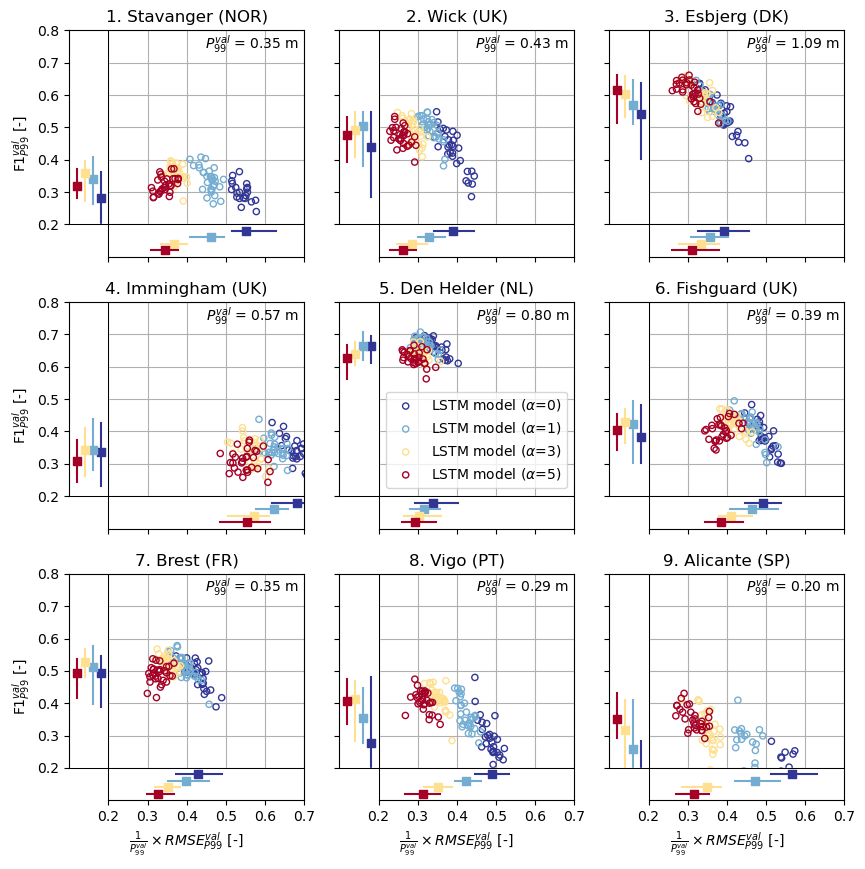

In [5]:
#configure the plot
store_fig = 0 #flag to save output

out_split = 'val' #split to plot
out_q = .99 #quantile to plot

#make the figure 
fig=plt.figure(figsize=(10,10)) 
gs = fig.add_gridspec(3,3) #1 row, 3 columns
gs.update(wspace=.15)
gs.update(hspace=.2)

for t,tg in enumerate(tgs): #loop over locations
    ax = plt.subplot(gs[np.unravel_index(t,(3,3))]) #(a) RMSEs

    #plot fraction of 99th percentile as background color and annotate
    ax.grid(zorder=0)
    ax.text(.78,.92,'$P_{99}^{val}$ = '+"{:.2f}".format(observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split).values) + ' m',alpha=1,color='black',ha='center',transform=ax.transAxes)
    
    #plot performance values for each alpha and model
    for ia,a in enumerate(np.array([0,1,3,5])): 
        #plot LSTMs:
        #add label once, for first tg
        relrmses = lstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split=out_split).where(lstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a).values.flatten()/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split).values
        f1s = lstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split=out_split).where(lstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a).values.flatten()
        sc = ax.scatter(relrmses,
                        f1s,
            facecolor='None',edgecolor=alpha_cmap(a),label='LSTM model ('+'$ \\alpha $'+'='+str(a)+')',s=20,zorder=1)
        
        ax.plot([.18-ia*.02,.18-ia*0.02],[np.nanmin(f1s),np.nanmax(f1s)],color=alpha_cmap(a),zorder=3)
        ax.scatter([.18-ia*.02],[np.nanmedian(f1s)],c=[alpha_cmap(a)],marker='s',zorder=3)
        
        ax.plot([np.nanmin(relrmses),np.nanmax(relrmses)],[.18-ia*.02,.18-ia*.02],color=alpha_cmap(a),zorder=5)
        ax.scatter([np.nanmedian(relrmses)],[.18-ia*.02],c=[alpha_cmap(a)],marker='s',zorder=5)
        
    rec = matplotlib.patches.Rectangle((.1,.1-.1),.1,.7+.1,color='white',zorder=2)
    ax.add_patch(rec)

    rec1 = matplotlib.patches.Rectangle((.1,.1),.7,.1,color='white',zorder=4)
    ax.add_patch(rec1)
        
    ax.axhline(y=.2,color='black',linewidth=.75,zorder=6)
    ax.axvline(x=.2,color='black',linewidth=.75,zorder=6)
        
    ax.set_ylim([.1,.8])
    ax.set_xlim([.1,.7])
    
    ax.set_xticks([.2,.3,.4,.5,.6,.7])
    ax.set_yticks([.2,.3,.4,.5,.6,.7,.8])
    if np.mod(t,3)==0:
        ax.set_ylabel('F1$_{P99}^{val}$ [-]')
    else:
        ax.set_yticklabels([])

    if t>5:
        ax.set_xlabel(r'$\frac{{1}}{{P_{99}^{val}}} \times RMSE_{P99}^{val}$ [-]')
        
    else:
        ax.set_xticklabels([])
    ax.set_axisbelow(True)
    
    if t==4:
        ax.legend(bbox_to_anchor=(.17, .15))

    ax.set_title(str(t+1)+'. '+tgnames[t])
    
    ax.spines['left'].set_bounds(.2, .8)
    ax.spines['bottom'].set_bounds(.2, .7)
    for k, spine in ax.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(10)
if store_fig:
    fig.savefig('/home/jovyan/test_surge_models/nhess_figures/fig2_lstm_99_error_alphas.pdf',format='pdf',dpi=300,bbox_inches='tight') #store figure

Calculate some statistics of the effect of alpha (Section 3.1):

In [ ]:
rel_rmses = lstms.rmse_extremes.sel(quantile=.99).sel(split='val')/observed_thresholds.sel(quantile=.99).sel(split='val')
f1s = lstms.f1.sel(quantile=.99).sel(split='val')

print('minimum relative RMSE for alpha=0: '+str(rel_rmses.where(lstms.sel(split='val').hyperparameters.sel(p='dl_alpha')==0).min(dim=('it','i')).values))
print('minimum relative RMSE for alpha=5: '+str(rel_rmses.where(lstms.sel(split='val').hyperparameters.sel(p='dl_alpha')==5).min(dim=('it','i')).values))
print('average decrease in minimum relative RMSE by increasing alpha to 5: '+str((rel_rmses.where(lstms.sel(split='val').hyperparameters.sel(p='dl_alpha')==5).min(dim=('it','i'))/rel_rmses.where(lstms.sel(split='val').hyperparameters.sel(p='dl_alpha')==0).min(dim=('it','i'))).mean(dim='tg').values))
print('')
print('maximum F1 for alpha=0: '+str(f1s.where(lstms.sel(split='val').hyperparameters.sel(p='dl_alpha')==0).max(dim=('it','i')).values))
print('maximum F1 for alpha=5: '+str(f1s.where(lstms.sel(split='val').hyperparameters.sel(p='dl_alpha')==5).max(dim=('it','i')).values))

median_f1_by_alpha = xr.concat([f1s.where(lstms.sel(split='val').hyperparameters.sel(p='dl_alpha')==k).median(dim=('it','i')) for k in [0,1,3,5]],dim='alpha')
max_f1_by_alpha = xr.concat([f1s.where(lstms.sel(split='val').hyperparameters.sel(p='dl_alpha')==k).max(dim=('it','i')) for k in [0,1,3,5]],dim='alpha') #max for each alpha
print('median F1 improvement for alpha>0 [%]: ' + str((100*(median_f1_by_alpha.max(dim='alpha')-median_f1_by_alpha.sel(alpha=0))/median_f1_by_alpha.sel(alpha=0)).mean(dim='tg').values))
print('maximum F1 improvement for alpha>0 [%]: ' + str((100*(max_f1_by_alpha.max(dim='alpha')-max_f1_by_alpha.sel(alpha=0))/max_f1_by_alpha.sel(alpha=0)).mean(dim='tg').values))

Effect of density-based weighting on LSTM-model precision & recall (Figure D1):

In [ ]:
#configure the plot
store_fig = 0 #flag to save output

out_split = 'val' #split to plot
out_q = .99 #quantile to plot

#make the figure 
fig=plt.figure(figsize=(10,10)) 
gs = fig.add_gridspec(3,3) #1 row, 3 columns
gs.update(wspace=.15)
gs.update(hspace=.2)

for t,tg in enumerate(tgs): #loop over locations
    ax = plt.subplot(gs[np.unravel_index(t,(3,3))]) #(a) RMSEs
   
    ax.grid(zorder=0)

    #plot performance values for each alpha and model
    for ia,a in enumerate(np.array([0,1,3,5])): 
        #plot LSTMs:
        #add label once, for first tg
        relrmses = lstms.sel(tg=tg).recall.sel(quantile=out_q).sel(split=out_split).where(lstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a).values.flatten()
        f1s = lstms.sel(tg=tg).precision.sel(quantile=out_q).sel(split=out_split).where(lstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a).values.flatten()
        sc = ax.scatter(relrmses,
                        f1s,
            facecolor='None',edgecolor=alpha_cmap(a),label='LSTM model ('+'$ \\alpha $'+'='+str(a)+')',s=20,zorder=1)
        
        ax.plot([.08-ia*.02,.08-ia*0.02],[np.nanmin(f1s),np.nanmax(f1s)],color=alpha_cmap(a),zorder=5)
        ax.scatter([.08-ia*.02],[np.nanmedian(f1s)],c=[alpha_cmap(a)],marker='s',zorder=5)
        
        ax.plot([np.nanmin(relrmses),np.nanmax(relrmses)],[.08-ia*.02,.08-ia*.02],color=alpha_cmap(a),zorder=3)
        ax.scatter([np.nanmedian(relrmses)],[.08-ia*.02],c=[alpha_cmap(a)],marker='s',zorder=3)
       
    rec = matplotlib.patches.Rectangle((0,-.1),.1,1.1,color='white',zorder=4)
    ax.add_patch(rec)

    rec1 = matplotlib.patches.Rectangle((0,0),1,.1,color='white',zorder=2)
    ax.add_patch(rec1)
     
    ax.axhline(y=.1,color='black',linewidth=.75,zorder=6)
    ax.axvline(x=.1,color='black',linewidth=.75,zorder=6)
        
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    
    ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
    ax.set_yticks([.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
    if np.mod(t,3)==0:
        ax.set_ylabel('precision$^{val}_{P99}$ [-]')
    else:
        ax.set_yticklabels([])

    if t>5:
        ax.set_xlabel('recall$^{val}_{P99}$ [-]')
        
    else:
        ax.set_xticklabels([])
    ax.set_axisbelow(True)
    
    if t==4:
        ax.legend(bbox_to_anchor=(.14, .62),loc='upper left')

    ax.set_title(str(t+1)+'. '+tgnames[t])
    
    ax.spines['left'].set_bounds(.1, 1)
    ax.spines['bottom'].set_bounds(.1, 1)
    for k, spine in ax.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(10)
if store_fig:
    fig.savefig('/home/jovyan/test_surge_models/nhess_figures/sfig4_precision_recall.pdf',format='pdf',dpi=300,bbox_inches='tight') #store figure

Plot comparison of model performances in validation split (Figure 3):

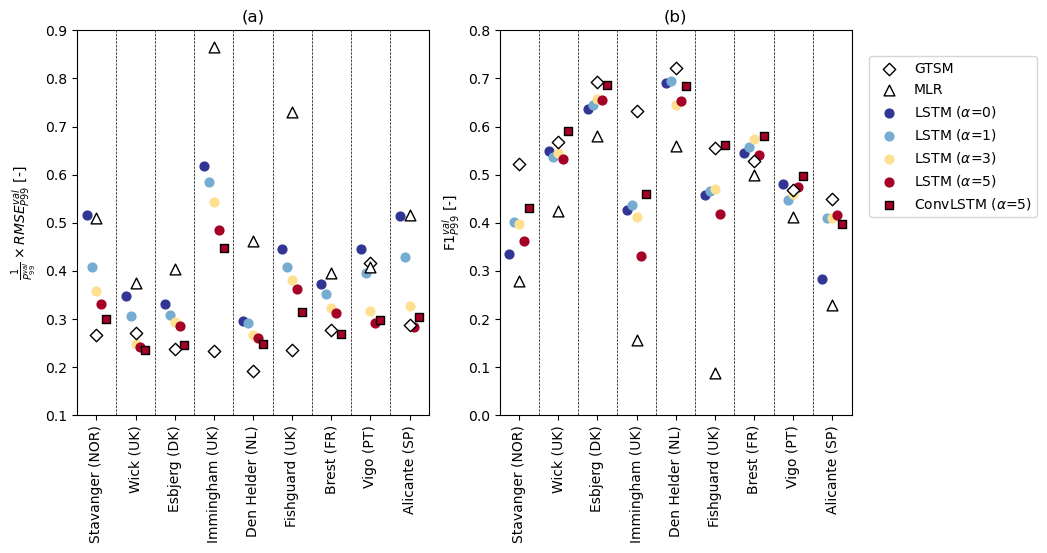

In [9]:
#configure the plot
store_fig = 1 #flag to save output

out_split = 'val' #split to plot
out_q = .99 #quantile to plot

plot_mlr_and_gtsm = 1 #whether to plot mlr and gtsm
plot_convlstm = 1 #whether to plot convlstm

#generate figure 
fig=plt.figure(figsize=(10,5)) 
gs = fig.add_gridspec(1,2) #1 row, 3 columns
gs.update(wspace=.2)

#(a) RMSEs
ax = plt.subplot(gs[0,0]) 
for t,tg in enumerate(tgs): #loop over locations
    ax.axvline(x=t+.5,color='black',linewidth=.5,linestyle='dashed')
    
    these_lstm_rmses = []
    these_convlstm_rmses = []
 
    #plot CoDEC & MLR RMSEs
    if plot_mlr_and_gtsm:
        if t==0: #add label once
            ax.scatter(t,codec.rmse_extremes.sel(tg=tg).sel(quantile=out_q).sel(split=out_split)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),color='white',edgecolor='black',zorder=10,marker=gtsm_marker,label='GTSM',s=gtsm_marker_size)
            ax.scatter(t,mlr.rmse_extremes.sel(tg=tg).sel(quantile=out_q).sel(split=out_split)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),color='white',edgecolor='black',zorder=10,marker=mlr_marker,label='MLR',s=mlr_marker_size)
        else:
            ax.scatter(t,codec.rmse_extremes.sel(tg=tg).sel(quantile=out_q).sel(split=out_split)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),color='white',edgecolor='black',zorder=10,marker=gtsm_marker,s=gtsm_marker_size)
            ax.scatter(t,mlr.rmse_extremes.sel(tg=tg).sel(quantile=out_q).sel(split=out_split)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),color='white',edgecolor='black',zorder=10,marker=mlr_marker,s=mlr_marker_size)

    for ia,a in enumerate(np.array([0,1,3,5])):
        #find "best" models per alpha:

        #1: obtain list of all rmses and f1s
        lstm_rmse = lstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split=out_split).where(lstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a,drop=True).values.flatten()
        lstm_f1 = lstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split=out_split).where(lstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a,drop=True).values.flatten()
        #2: find highest combined ranked model
        best_ranked_lstm = np.argmin(np.argsort(lstm_rmse).argsort() + np.argsort(lstm_f1)[::-1].argsort())
        
        if a==5: #same for convlstms
            convlstm_rmse = convlstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split=out_split).where(convlstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a,drop=True).values.flatten()
            convlstm_f1 = convlstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split=out_split).where(convlstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a,drop=True).values.flatten()
            best_ranked_convlstm = np.argmin(np.argsort(convlstm_rmse).argsort() + np.argsort(convlstm_f1)[::-1].argsort())
        
        #plot RMSE of best LSTM & ConvLSTM models
        if t==0: #add label once
            sc = ax.scatter(t-.25+ia*.125,lstm_rmse[best_ranked_lstm]/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),facecolor=alpha_cmap(a),label='LSTM ('+'$ \\alpha $'+'='+str(a)+')',s=nn_marker_size)
            
            if a==5:
                if plot_convlstm:
                    ax.scatter(t+.25,convlstm_rmse[best_ranked_convlstm]/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),facecolor=alpha_cmap(a),marker=convlstm_marker,edgecolor='black',
                               label='ConvLSTM ('+'$ \\alpha $'+'='+str(a)+')',s=convlstm_marker_size)
        else:
            ax.scatter(t-.25+ia*.125,lstm_rmse[best_ranked_lstm]/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),facecolor=alpha_cmap(a),s=nn_marker_size)
            
            if a==5:
                if plot_convlstm:
                    ax.scatter(t+.25,convlstm_rmse[best_ranked_convlstm]/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),facecolor=alpha_cmap(a),marker=convlstm_marker,edgecolor='black',s=convlstm_marker_size)
     
ax.legend(bbox_to_anchor=(2.23, .95), loc='upper left')  
ax.set_xticks(np.arange(len(tgs)),tgnames,rotation=90) #add location names
ax.set_ylim([.1,.9])
ax.set_xlim([-.5,8.5])
ax.set_ylabel(r'$\frac{{1}}{{P_{99}^{val}}} \times RMSE_{P99}^{val}$ [-]')
ax.set_title('(a)')

 #(b) plot F1 score
ax = plt.subplot(gs[0,1]) 
for t,tg in enumerate(tgs):
    ax.axvline(x=t+.5,color='black',linewidth=.5,linestyle='dashed')
    
    these_lstm_f1 = []
    these_convlstm_f1 = []
    
    if plot_mlr_and_gtsm:
        ax.scatter(t,codec.f1.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),color='white',edgecolor='black',zorder=10,marker=gtsm_marker,s=gtsm_marker_size)
        ax.scatter(t,mlr.f1.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),color='white',edgecolor='black',zorder=10,marker=mlr_marker,s=mlr_marker_size)
    
    for ia,a in enumerate(np.array([0,1,3,5])):
        #same as for RMSEs in subplot a, determine best ranked models for each alpha
        lstm_rmse = lstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split=out_split).where(lstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a,drop=True).values.flatten()
        lstm_f1 = lstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split=out_split).where(lstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a,drop=True).values.flatten()
        best_ranked_lstm = np.argmin(np.argsort(lstm_rmse).argsort() + np.argsort(lstm_f1)[::-1].argsort())
        if a==5:
            if plot_convlstm:
                convlstm_rmse = convlstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split=out_split).where(convlstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a,drop=True).values.flatten()
                convlstm_f1 = convlstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split=out_split).where(convlstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a,drop=True).values.flatten()
                best_ranked_convlstm = np.argmin(np.argsort(convlstm_rmse).argsort() + np.argsort(convlstm_f1)[::-1].argsort())
        
        ax.scatter(t-.25+ia*.125,lstm_f1[best_ranked_lstm],facecolor=alpha_cmap(a),s=nn_marker_size)
        
        if a==5:
            if plot_convlstm:
                ax.scatter(t+.25,convlstm_f1[best_ranked_convlstm],facecolor=alpha_cmap(a),marker=convlstm_marker,edgecolor='black',s=convlstm_marker_size)
        
ax.set_xticks(np.arange(len(tgs)),tgnames,rotation=90)
ax.set_ylim([0,.8])
ax.set_xlim([-.5,8.5])
ax.set_ylabel('F1$_{P99}^{val}$ [-]')
ax.set_title('(b)')

if store_fig:
    fig.savefig('/home/jovyan/test_surge_models/nhess_figures/fig3_model_comparison_test.pdf',format='pdf',dpi=300,bbox_inches='tight') #store figure

Calculate some statistics on the model intercomparison (Section 3.2):

In [ ]:
'''
print('Mean reduction RMSE to convlstm from lstm a=5: ' + str(np.mean((np.array(lowest_convlstm_rmse)-np.array(lowest_lstm_a5_rmse))/np.array(lowest_lstm_a5_rmse))))
print('Mean reduction RMSE to GTSM from lstm a=5: ' + str(np.mean((np.array(codec.rmse_extremes.sel(tg=tgs).sel(quantile=out_q).sel(split=out_split).values)-np.array(lowest_lstm_a5_rmse))/np.array(lowest_lstm_a5_rmse))))
print('Mean increase F1 to convlstm from lstm a=5: '+str(np.mean((np.array(highest_convlstm_f1)-np.array(highest_lstm_a5_f1))/np.array(highest_lstm_a5_f1))))
print('Mean increase F1 to GTSM from all lstm: '+str(np.mean((np.array(codec.f1.sel(tg=tgs).sel(quantile=out_q).sel(split=out_split).values)-np.array(highest_lstm_f1))/np.array(highest_lstm_f1))))
print('Mean reduction RMSE from convlstm to GTSM: ' + str(np.mean(((codec.rmse_extremes.sel(tg=tgs).sel(quantile=out_q).sel(split=out_split).values-np.array(lowest_convlstm_rmse))/np.array(lowest_convlstm_rmse))[np.array([1,2,4,5,6,7,8])])))
print('Mean increase F1 from convlstm to GTSM: ' + str(np.mean(((codec.f1.sel(tg=tgs).sel(quantile=out_q).sel(split=out_split).values-np.array(highest_convlstm_f1))/np.array(highest_convlstm_f1))[np.array([1,2,4,5,6,7,8])])))
print('Mean increase RMSE from lstm a=0 to MLR: '+str(np.mean(fraction_higher_mlr_than_lstm_alpha0)))
'''

**For testing:**

Text(0.5, 1.0, '(b)')

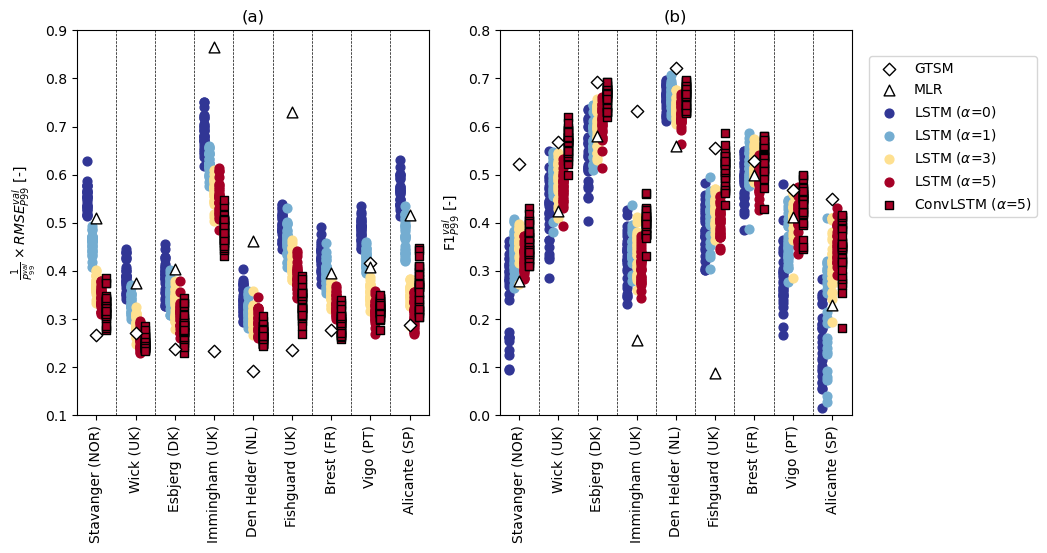

In [7]:
out_split = 'val' #split to plot
out_q = .99 #quantile to plot

plot_mlr_and_gtsm = 1 #whether to plot mlr and gtsm
plot_convlstm = 1 #whether to plot convlstm

gtsm_marker = 'D'
mlr_marker = '^'
convlstm_marker='s'

nn_marker_size=40
gtsm_marker_size=40
mlr_marker_size = 60
convlstm_marker_size = 40

threshold_color = 'black'
mlrcolor = 'white'

#to store some statistics
lowest_lstm_rmse=[]
highest_lstm_f1=[]

lowest_lstm_a5_rmse=[]
highest_lstm_a5_f1=[]

lowest_convlstm_rmse=[]
highest_convlstm_f1=[]

fraction_higher_mlr_than_lstm_alpha0 = []

alpha_cmap = plt.get_cmap('RdYlBu_r', 6) #alpha colormap

#generate figure 
fig=plt.figure(figsize=(10,5)) 
gs = fig.add_gridspec(1,2) #1 row, 3 columns
gs.update(wspace=.2)

ax = plt.subplot(gs[0,0]) #(a) RMSEs
for t,tg in enumerate(tgs): #loop over locations
    ax.axvline(x=t+.5,color='black',linewidth=.5,linestyle='dashed')
    
    these_lstm_rmses = []
    these_convlstm_rmses = []
    
    ''''
    #plot fraction of 99th percentile as background color and annotate
    for p,pct in enumerate(np.arange(0,1.1,.1)): 
        ax.fill_between([t-.4,t+.4], (pct-.1)*observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split), 
                        y2=pct*observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),
                        alpha=pct*.8,color=threshold_color,edgecolor='None')
        
    ax.text(t,-.055,'0',alpha=.1,color=threshold_color,ha='center')
    ax.text(t,.02+observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),'P$_{99}$',alpha=1,color=threshold_color,ha='center')
    '''
    
    #plot CoDEC & MLR RMSEs
    if plot_mlr_and_gtsm:
        if t==0: #add label once
            ax.scatter(t,codec.rmse_extremes.sel(tg=tg).sel(quantile=out_q).sel(split=out_split)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),color='white',edgecolor='black',zorder=10,marker=gtsm_marker,label='GTSM',s=gtsm_marker_size)
            ax.scatter(t,mlr.rmse_extremes.sel(tg=tg).sel(quantile=out_q).sel(split=out_split)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),color=mlrcolor,edgecolor='black',zorder=10,marker=mlr_marker,label='MLR',s=mlr_marker_size)
        else:
            ax.scatter(t,codec.rmse_extremes.sel(tg=tg).sel(quantile=out_q).sel(split=out_split)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),color='white',edgecolor='black',zorder=10,marker=gtsm_marker,s=gtsm_marker_size)
            ax.scatter(t,mlr.rmse_extremes.sel(tg=tg).sel(quantile=out_q).sel(split=out_split)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),color=mlrcolor,edgecolor='black',zorder=10,marker=mlr_marker,s=mlr_marker_size)

    for ia,a in enumerate(np.array([0,1,3,5])):
        #find "best" models per alpha:

        #1: obtain list of all rmses and f1s
        lstm_rmse = lstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split=out_split).where(lstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a,drop=True).values.flatten()
        lstm_f1 = lstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split=out_split).where(lstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a,drop=True).values.flatten()
        #2: find highest combined ranked model
        best_ranked_lstm = np.argmin(np.argsort(lstm_rmse).argsort() + np.argsort(lstm_f1)[::-1].argsort())
        if a==0:
            fraction_higher_mlr_than_lstm_alpha0.append((mlr.rmse_extremes.sel(tg=tg).sel(quantile=out_q).sel(split=out_split).values-lstm_rmse[best_ranked_lstm])/lstm_rmse[best_ranked_lstm])
        if a==5: #same for convlstms
            convlstm_rmse = convlstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split=out_split).where(convlstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a,drop=True).values.flatten()
            convlstm_f1 = convlstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split=out_split).where(convlstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a,drop=True).values.flatten()
            best_ranked_convlstm = np.argmin(np.argsort(convlstm_rmse).argsort() + np.argsort(convlstm_f1)[::-1].argsort())
        
        #plot RMSE of best LSTM & ConvLSTM models
        if t==0: #add label once
            sc = ax.scatter(t-.25+ia*.125+np.zeros(len(lstm_rmse)),lstm_rmse/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split).values,facecolor=alpha_cmap(a),label='LSTM ('+'$ \\alpha $'+'='+str(a)+')',s=nn_marker_size)
            
            if a==5:
                if plot_convlstm:
                    ax.scatter(t+.25+np.zeros(len(convlstm_rmse)),convlstm_rmse/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split).values,facecolor=alpha_cmap(a),marker=convlstm_marker,edgecolor='black',
                               label='ConvLSTM ('+'$ \\alpha $'+'='+str(a)+')',s=convlstm_marker_size)
        else:
            ax.scatter(t-.25+ia*.125+np.zeros(len(lstm_rmse)),lstm_rmse/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split).values,facecolor=alpha_cmap(a),s=nn_marker_size)
            
            if a==5:
                if plot_convlstm:
                    ax.scatter(t+.25+np.zeros(len(convlstm_rmse)),convlstm_rmse/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split).values,facecolor=alpha_cmap(a),marker=convlstm_marker,edgecolor='black',s=convlstm_marker_size)
        
        if a==5: #store some statistics
            lowest_lstm_a5_rmse.append(lstm_rmse[best_ranked_lstm])
            lowest_convlstm_rmse.append(convlstm_rmse[best_ranked_convlstm])
            
        these_lstm_rmses.append(lstm_rmse[best_ranked_lstm])
    lowest_lstm_rmse.append(np.nanmin(these_lstm_rmses))
    
ax.legend(bbox_to_anchor=(2.23, .95), loc='upper left')  
ax.set_xticks(np.arange(len(tgs)),tgnames,rotation=90) #add location names
ax.set_ylim([.1,.9])
ax.set_xlim([-.5,8.5])
ax.set_ylabel(r'$\frac{{1}}{{P_{99}^{val}}} \times RMSE_{P99}^{val}$ [-]')
ax.set_title('(a)')

ax = plt.subplot(gs[0,1])  #(b) plot F1 score
for t,tg in enumerate(tgs):
    ax.axvline(x=t+.5,color='black',linewidth=.5,linestyle='dashed')
    
    these_lstm_f1 = []
    these_convlstm_f1 = []
    
    if plot_mlr_and_gtsm:
        ax.scatter(t,codec.f1.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),color='white',edgecolor='black',zorder=10,marker=gtsm_marker,s=gtsm_marker_size)
        ax.scatter(t,mlr.f1.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),color=mlrcolor,edgecolor='black',zorder=10,marker=mlr_marker,s=mlr_marker_size)
    
    for ia,a in enumerate(np.array([0,1,3,5])):
        #same as for RMSEs in subplot a, determine best ranked models for each alpha
        lstm_rmse = lstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split=out_split).where(lstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a,drop=True).values.flatten()
        lstm_f1 = lstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split=out_split).where(lstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a,drop=True).values.flatten()
        best_ranked_lstm = np.argmin(np.argsort(lstm_rmse).argsort() + np.argsort(lstm_f1)[::-1].argsort())
        if a==5:
            if plot_convlstm:
                convlstm_rmse = convlstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split=out_split).where(convlstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a,drop=True).values.flatten()
                convlstm_f1 = convlstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split=out_split).where(convlstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a,drop=True).values.flatten()
                best_ranked_convlstm = np.argmin(np.argsort(convlstm_rmse).argsort() + np.argsort(convlstm_f1)[::-1].argsort())
        
        ax.scatter(t-.25+ia*.125+np.zeros(len(lstm_f1)),lstm_f1,facecolor=alpha_cmap(a),s=nn_marker_size)
        
        if a==5:
            if plot_convlstm:
                ax.scatter(t+.25+np.zeros(len(convlstm_f1)),convlstm_f1,facecolor=alpha_cmap(a),marker=convlstm_marker,edgecolor='black',s=convlstm_marker_size)
        
        if a==5: #store some statistics
            highest_lstm_a5_f1.append(lstm_f1[best_ranked_lstm])
            highest_convlstm_f1.append(convlstm_f1[best_ranked_convlstm])  
        these_lstm_f1.append(lstm_f1[best_ranked_lstm])
    highest_lstm_f1.append(np.nanmax(these_lstm_f1))
    
ax.set_xticks(np.arange(len(tgs)),tgnames,rotation=90)
ax.set_ylim([0,.8])
ax.set_xlim([-.5,8.5])
ax.set_ylabel('F1$_{P99}^{val}$ [-]')
ax.set_title('(b)')

**For testing (add other models to fig2)**:

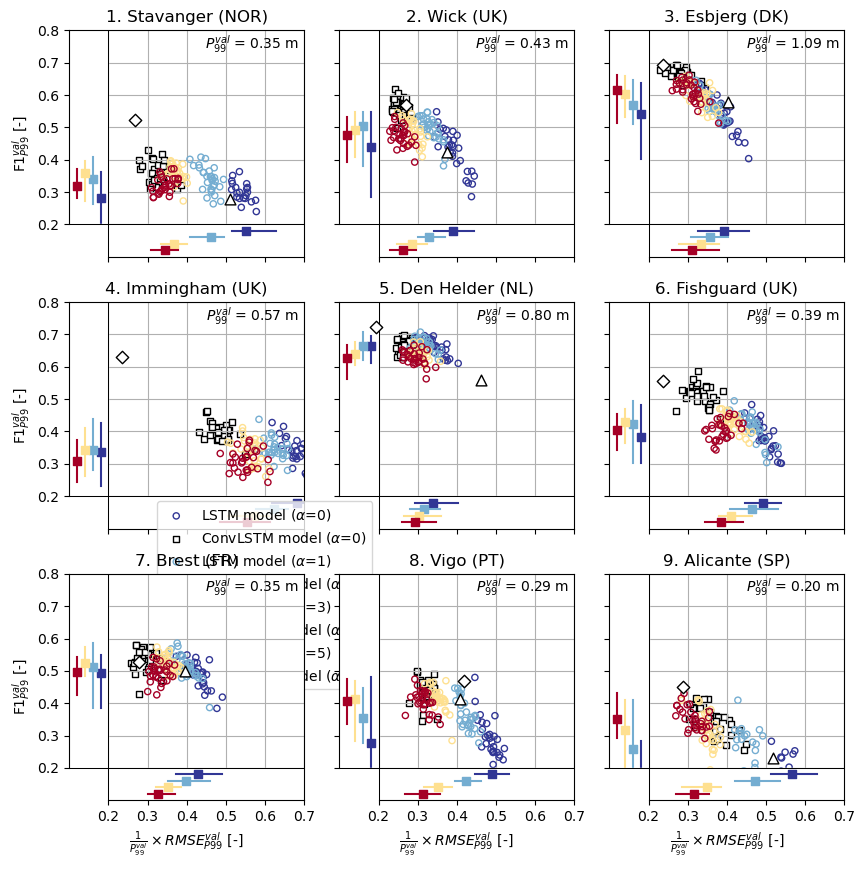

In [8]:
#configure the plot
store_fig = 0 #flag to save output

out_split = 'val' #split to plot
out_q = .99 #quantile to plot

nn_marker_size=40 
threshold_color = 'black' #colorbars for errors relative to p99

alpha_cmap = plt.get_cmap('RdYlBu_r', 6) #alpha colormap

#make the figure 
fig=plt.figure(figsize=(10,10)) 
gs = fig.add_gridspec(3,3) #1 row, 3 columns
gs.update(wspace=.15)
gs.update(hspace=.2)


lowest_rmses_a0 = [] #to store some statistics
lowest_rmses_a5 = []
highest_f1_a0 = []
highest_f1_aHt0 = [] #alpha higher than 0

for t,tg in enumerate(tgs): #loop over locations
    #ax.axvline(x=t+.5,color='black',linewidth=.5,linestyle='dashed') #separate locations
    ax = plt.subplot(gs[np.unravel_index(t,(3,3))]) #(a) RMSEs

    ax.grid(zorder=0)
    ax.text(.78,.92,'$P_{99}^{val}$ = '+"{:.2f}".format(observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split).values) + ' m',alpha=1,color=threshold_color,ha='center',transform=ax.transAxes)
    
    #plot performance values for each alpha and model
    for ia,a in enumerate(np.array([0,1,3,5])): 
        #plot LSTMs:
        #add label once, for first tg
        relrmses = lstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split=out_split).where(lstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a).values.flatten()/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split).values
        f1s = lstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split=out_split).where(lstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a).values.flatten()
        sc = ax.scatter(relrmses,
                        f1s,
            facecolor='None',edgecolor=alpha_cmap(a),label='LSTM model ('+'$ \\alpha $'+'='+str(a)+')',s=20,zorder=1)
        
        
        #plot convlstms:
        conv_relrmses = convlstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split=out_split).where(convlstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a).values.flatten()/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split).values
        conv_f1s = convlstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split=out_split).where(convlstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha')==a).values.flatten()
        sc = ax.scatter(conv_relrmses,
                        conv_f1s,
            facecolor='white',edgecolor='black',label='ConvLSTM model ('+'$ \\alpha $'+'='+str(a)+')',marker='s',s=20,zorder=0)
        
        
        ax.plot([.18-ia*.02,.18-ia*0.02],[np.nanmin(f1s),np.nanmax(f1s)],color=alpha_cmap(a),zorder=3)
        ax.scatter([.18-ia*.02],[np.nanmedian(f1s)],c=[alpha_cmap(a)],marker='s',zorder=3)
        
        ax.plot([np.nanmin(relrmses),np.nanmax(relrmses)],[.18-ia*.02,.18-ia*.02],color=alpha_cmap(a),zorder=5)
        ax.scatter([np.nanmedian(relrmses)],[.18-ia*.02],c=[alpha_cmap(a)],marker='s',zorder=5)
        
    #test adding other models in this plot:
    ax.scatter(codec.rmse_extremes.sel(tg=tg).sel(quantile=out_q).sel(split=out_split)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),codec.f1.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),color='white',edgecolor='black',zorder=10,marker=gtsm_marker,s=gtsm_marker_size)
    ax.scatter(mlr.rmse_extremes.sel(tg=tg).sel(quantile=out_q).sel(split=out_split)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),mlr.f1.sel(tg=tg).sel(quantile=out_q).sel(split=out_split),color=mlrcolor,edgecolor='black',zorder=10,marker=mlr_marker,s=mlr_marker_size)
        
    rec = matplotlib.patches.Rectangle((.1,.1-.1),.1,.7+.1,color='white',zorder=2)
    ax.add_patch(rec)

    rec1 = matplotlib.patches.Rectangle((.1,.1),.7,.1,color='white',zorder=4)
    ax.add_patch(rec1)
        
    ax.axhline(y=.2,color='black',linewidth=.75,zorder=6)
    ax.axvline(x=.2,color='black',linewidth=.75,zorder=6)
        
    ax.set_ylim([.1,.8])
    ax.set_xlim([.1,.7])
    
    ax.set_xticks([.2,.3,.4,.5,.6,.7])
    ax.set_yticks([.2,.3,.4,.5,.6,.7,.8])
    if np.mod(t,3)==0:
        ax.set_ylabel('F1$_{P99}^{val}$ [-]')
    else:
        ax.set_yticklabels([])
  
    if t>5:
        ax.set_xlabel(r'$\frac{{1}}{{P_{99}^{val}}} \times RMSE_{P99}^{val}$ [-]')
        
    else:
        ax.set_xticklabels([])
    ax.set_axisbelow(True)
    
    if t==4:
        ax.legend(bbox_to_anchor=(.17, .15))

    #if t==8:
    #    ax.legend(bbox_to_anchor=(-2.33, -.25), loc='upper left',ncol=4)

    ax.set_title(str(t+1)+'. '+tgnames[t])
    
    ax.spines['left'].set_bounds(.2, .8)
    ax.spines['bottom'].set_bounds(.2, .7)
    for k, spine in ax.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(10)


Plot manuscript Figure 4 - validation v.s. test split:

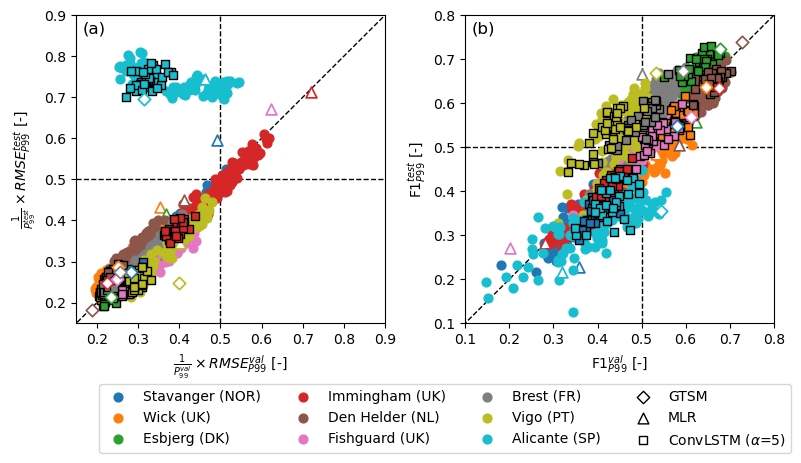

In [15]:
#configure the plot
store_fig = 0 #flag to save output

out_split = 'val' #split to plot
out_q = .99 #quantile to plot

gtsm_marker = 'D'
mlr_marker = '^'
convlstm_marker='s'

nn_marker_size=40
gtsm_marker_size=40
mlr_marker_size = 60
convlstm_marker_size = 40

fig=plt.figure(figsize=(9,4)) 
gs = fig.add_gridspec(1,2)
gs.update(wspace=.26)
cmap = plt.get_cmap('tab10', 9)

ax = plt.subplot(gs[0,0]) #RMSE
metric = 'rmse_extremes'   
for t,tg in enumerate(tgs):
    ax.scatter(lstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='val').values.flatten()/observed_thresholds.sel(tg=tg).isel(quantile=2,split=1).values,
                    lstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='test').values.flatten()/observed_thresholds.sel(tg=tg).isel(quantile=2,split=2).values,
                    label=tgnames[t],zorder=0,c=[cmap(t)],s=nn_marker_size)
    ax.scatter(convlstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='val').values.flatten()/observed_thresholds.sel(tg=tg).isel(quantile=2,split=1).values,
                    convlstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='test').values.flatten()/observed_thresholds.sel(tg=tg).isel(quantile=2,split=2).values,
                    c=[cmap(t)],s=convlstm_marker_size,edgecolor='black',zorder=5,marker=convlstm_marker)
    
    ax.scatter(codec[metric].sel(tg=tg).sel(quantile=out_q).sel(split='val')/observed_thresholds.sel(tg=tg).isel(quantile=2,split=1).values,
               codec[metric].sel(tg=tg).sel(quantile=out_q).sel(split='test')/observed_thresholds.sel(tg=tg).isel(quantile=2,split=2).values,edgecolor=[cmap(t)],marker=gtsm_marker,zorder=8,facecolor='white',s=gtsm_marker_size,linewidth=1.25)
    
    ax.scatter(mlr.rmse_extremes.sel(tg=tg).sel(quantile=out_q).sel(split='val')/observed_thresholds.sel(tg=tg).isel(quantile=2,split=1).values,
               mlr.rmse_extremes.sel(tg=tg).sel(quantile=out_q).sel(split='test')/observed_thresholds.sel(tg=tg).isel(quantile=2,split=2).values,edgecolor=[cmap(t)],marker=mlr_marker,zorder=0,facecolor='white',s=mlr_marker_size,linewidth=1.25)
ax.text(.02,.94,'(a)',transform=ax.transAxes,fontsize=12,zorder=20)    
ax.set_xlim([.15,.9]) 
ax.set_ylim([.15,.9])
ax.set_yticks(np.arange(.2,1,.1))
ax.set_xticks(np.arange(.2,1,.1))

ax.axhline(y=.5,color='black',linestyle='dashed',linewidth=1,zorder=-1)
ax.axvline(x=.5,color='black',linestyle='dashed',linewidth=1,zorder=-1)
ax.plot([0,1],[0,1],color='black',linestyle='dashed',linewidth=1,zorder=-1)
ax.set_ylabel(r'$\frac{{1}}{{P_{99}^{test}}} \times RMSE_{P99}^{test}$ [-]')
ax.set_xlabel(r'$\frac{{1}}{{P_{99}^{val}}} \times RMSE_{P99}^{val}$ [-]')


ax = plt.subplot(gs[0,1])
metric = 'f1'   
for t,tg in enumerate(tgs):
    ax.scatter(lstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='val').values.flatten(),
                    lstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='test').values.flatten(),
                    label=tgnames[t],zorder=0,c=[cmap(t)],s=nn_marker_size)
    ax.scatter(convlstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='val').values.flatten(),
                    convlstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='test').values.flatten(),
                    c=[cmap(t)],s=convlstm_marker_size,edgecolor='black',zorder=5,marker=convlstm_marker)
    ax.scatter(codec[metric].sel(tg=tg).sel(quantile=out_q).sel(split='val'),
               codec[metric].sel(tg=tg).sel(quantile=out_q).sel(split='test'),edgecolor=[cmap(t)],marker=gtsm_marker,zorder=7,facecolor='white',s=gtsm_marker_size,linewidth=1.25)
    ax.scatter(mlr[metric].sel(tg=tg).sel(quantile=out_q).sel(split='val'),
               mlr[metric].sel(tg=tg).sel(quantile=out_q).sel(split='test'),edgecolor=[cmap(t)],marker=mlr_marker,zorder=0,facecolor='white',s=mlr_marker_size,linewidth=1.25)
    
ax.scatter(-1,-1,edgecolor='black',marker=gtsm_marker,zorder=5,facecolor='white',s=40,label='GTSM')
ax.scatter(-1,-1,edgecolor='black',marker=mlr_marker,zorder=5,facecolor='white',s=60,label='MLR')
ax.scatter(-1,-1,edgecolor='black',marker=convlstm_marker,zorder=5,facecolor='white',s=30,label='ConvLSTM ($\\alpha$=5)')
ax.text(.02,.94,'(b)',transform=ax.transAxes,fontsize=12)
ax.set_xlim([0.1,.8]) 
ax.set_ylim([0.1,.8])
ax.axhline(y=.5,color='black',linestyle='dashed',linewidth=1,zorder=-1)
ax.axvline(x=.5,color='black',linestyle='dashed',linewidth=1,zorder=-1)
ax.plot([0,1],[0,1],color='black',linestyle='dashed',linewidth=1,zorder=-1)
ax.set_ylabel('F1$_{P99}^{test}$ [-]')
ax.set_xlabel('F1$_{P99}^{val}$ [-]')
ax.legend(bbox_to_anchor=(-1.21, -.175), loc='upper left',ncol=4)

if store_fig:
    fig.savefig('../nhess_figures/fig4_val_vs_test.pdf',format='pdf',dpi=300,bbox_inches='tight') #store figure


/tmp/ipykernel_3339/1102207518.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(convlstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='val').values.flatten()/observed_thresholds.sel(tg=tg).isel(quantile=2,split=1).values,
/tmp/ipykernel_3339/1102207518.py:61: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(convlstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='val').values.flatten(),


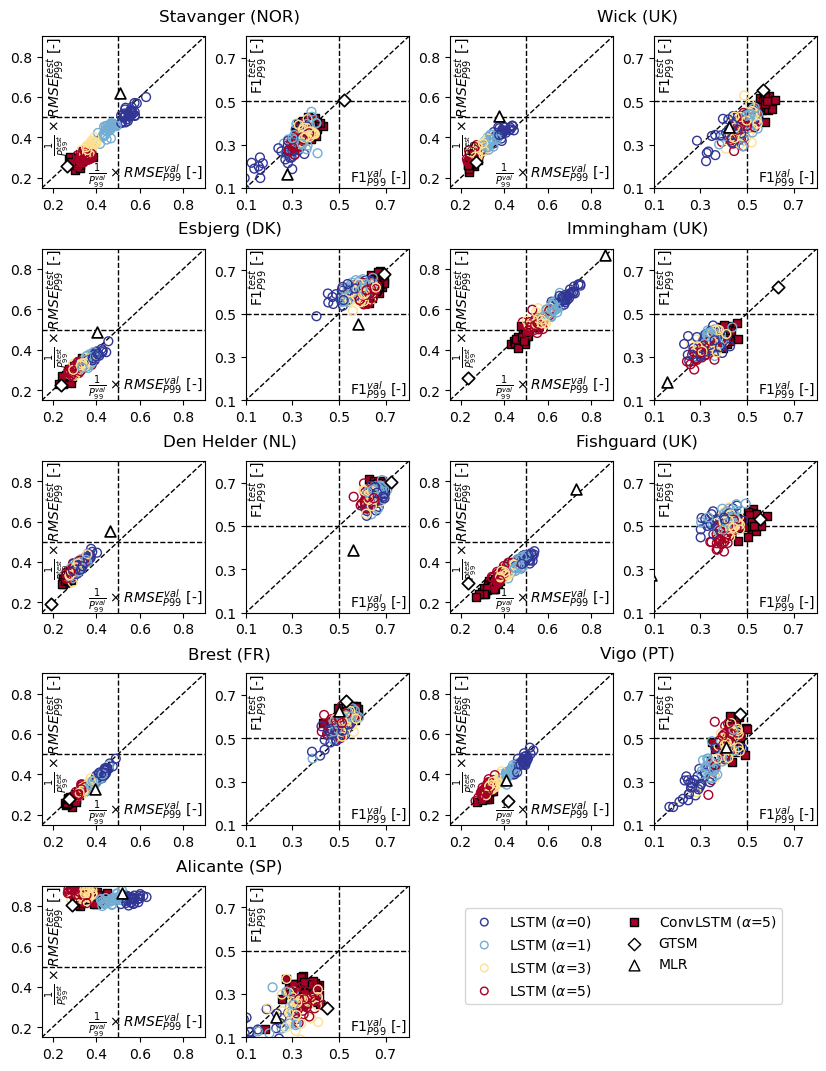

In [12]:
#configure the plot
store_fig = 1 #flag to save output

out_split = 'val' #split to plot
out_q = .99 #quantile to plot
alpha_cmap = plt.get_cmap('RdYlBu_r', 6) #alpha colormap

gtsm_marker = 'D'
mlr_marker = '^'
convlstm_marker='s'

nn_marker_size=40
gtsm_marker_size=40
mlr_marker_size = 60
convlstm_marker_size = 40

fig=plt.figure(figsize=(10,13)) #10,14
gs = fig.add_gridspec(5,4)
gs.update(wspace=.25,hspace=.4)
cmap = plt.get_cmap('tab10', 9)

 #RMSE
metric = 'rmse_extremes'   
for t,tg in enumerate(tgs):
    ax = plt.subplot(gs[t//2,t%2*2])
    ax.scatter(lstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='val').values.flatten()/observed_thresholds.sel(tg=tg).isel(quantile=2,split=1).values,
                    lstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='test').values.flatten()/observed_thresholds.sel(tg=tg).isel(quantile=2,split=2).values,
                    zorder=2,facecolor='None',edgecolor=alpha_cmap(lstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha').values.flatten().astype('int')),s=nn_marker_size)
    ax.scatter(convlstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='val').values.flatten()/observed_thresholds.sel(tg=tg).isel(quantile=2,split=1).values,
                    convlstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='test').values.flatten()/observed_thresholds.sel(tg=tg).isel(quantile=2,split=2).values,
                    c=alpha_cmap(5),s=convlstm_marker_size,edgecolor='black',zorder=1,marker=convlstm_marker)
    
    ax.scatter(codec[metric].sel(tg=tg).sel(quantile=out_q).sel(split='val')/observed_thresholds.sel(tg=tg).isel(quantile=2,split=1).values,
               codec[metric].sel(tg=tg).sel(quantile=out_q).sel(split='test')/observed_thresholds.sel(tg=tg).isel(quantile=2,split=2).values,
               edgecolor='black',marker=gtsm_marker,facecolor='white',s=gtsm_marker_size,linewidth=1.25,zorder=4)
    
    ax.scatter(mlr.rmse_extremes.sel(tg=tg).sel(quantile=out_q).sel(split='val')/observed_thresholds.sel(tg=tg).isel(quantile=2,split=1).values,
               mlr.rmse_extremes.sel(tg=tg).sel(quantile=out_q).sel(split='test')/observed_thresholds.sel(tg=tg).isel(quantile=2,split=2).values,
               edgecolor='black',marker=mlr_marker,facecolor='white',s=mlr_marker_size,linewidth=1.25,zorder=3)
    ax.text(1.15,1.1,tgnames[t],transform=ax.transAxes,fontsize=12,zorder=20,ha='center')    
    ax.text(.01,.3,r'$\frac{{1}}{{P_{99}^{test}}} \times RMSE_{P99}^{test}$ [-]',transform=ax.transAxes,fontsize=10,zorder=20,rotation=90)    
    ax.text(.28,.07,r'$\frac{{1}}{{P_{99}^{val}}} \times RMSE_{P99}^{val}$ [-]',transform=ax.transAxes,fontsize=10,zorder=20)  
    ax.set_xlim([.15,.9]) 
    ax.set_ylim([.15,.9])
    ax.set_yticks(np.arange(.2,1,.2))
    ax.set_xticks(np.arange(.2,1,.2))

    ax.axhline(y=.5,color='black',linestyle='dashed',linewidth=1,zorder=-1)
    ax.axvline(x=.5,color='black',linestyle='dashed',linewidth=1,zorder=-1)
    ax.plot([0,1],[0,1],color='black',linestyle='dashed',linewidth=1,zorder=-1)
    #ax.set_ylabel(r'$\frac{{1}}{{P_{99}^{test}}} \times RMSE_{P99}^{test}$ [-]')
    #ax.set_xlabel(r'$\frac{{1}}{{P_{99}^{val}}} \times RMSE_{P99}^{val}$ [-]')


metric = 'f1'   
for t,tg in enumerate(tgs):
    ax = plt.subplot(gs[t//2,1+t%2*2])
    ax.scatter(lstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='val').values.flatten(),
                    lstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='test').values.flatten(),
                    zorder=2,facecolor='None',edgecolor=alpha_cmap(lstms.sel(tg=tg).sel(split=out_split).hyperparameters.sel(p='dl_alpha').values.flatten().astype('int')),s=nn_marker_size)
    ax.scatter(convlstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='val').values.flatten(),
                    convlstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='test').values.flatten(),
                    c=alpha_cmap(5),s=convlstm_marker_size,edgecolor='black',zorder=1,marker=convlstm_marker)
    ax.scatter(codec[metric].sel(tg=tg).sel(quantile=out_q).sel(split='val'),
               codec[metric].sel(tg=tg).sel(quantile=out_q).sel(split='test'),
               edgecolor='black',marker=gtsm_marker,facecolor='white',s=gtsm_marker_size,linewidth=1.25,zorder=4)
    ax.scatter(mlr[metric].sel(tg=tg).sel(quantile=out_q).sel(split='val'),
               mlr[metric].sel(tg=tg).sel(quantile=out_q).sel(split='test'),
               edgecolor='black',marker=mlr_marker,facecolor='white',s=mlr_marker_size,linewidth=1.25,zorder=3)
    
    
    ax.scatter(-1,-1,marker='o',zorder=5,facecolor='None',edgecolor=alpha_cmap(0),s=30,label='LSTM ($\\alpha$=0)')
    ax.scatter(-1,-1,marker='o',zorder=5,facecolor='None',edgecolor=alpha_cmap(1),s=30,label='LSTM ($\\alpha$=1)')
    ax.scatter(-1,-1,marker='o',zorder=5,facecolor='None',edgecolor=alpha_cmap(3),s=30,label='LSTM ($\\alpha$=3)')
    ax.scatter(-1,-1,marker='o',zorder=5,facecolor='None',edgecolor=alpha_cmap(5),s=30,label='LSTM ($\\alpha$=5)')
    ax.scatter(-1,-1,edgecolor='black',marker=convlstm_marker,zorder=5,facecolor=alpha_cmap(5),s=30,label='ConvLSTM ($\\alpha$=5)')
    ax.scatter(-1,-1,edgecolor='black',marker=gtsm_marker,zorder=5,facecolor='white',s=40,label='GTSM')
    ax.scatter(-1,-1,edgecolor='black',marker=mlr_marker,zorder=5,facecolor='white',s=60,label='MLR')
    
    #
    ax.text(.01,.67,'F1$_{P99}^{test}$ [-]',transform=ax.transAxes,fontsize=10,zorder=20,rotation=90)    
    ax.text(.64,.04,'F1$_{P99}^{val}$ [-]',transform=ax.transAxes,fontsize=10,zorder=20)  
    
    ax.set_xlim([0.1,.8]) 
    ax.set_ylim([0.1,.8])
    ax.set_yticks([.1,.3,.5,.7])
    ax.set_xticks([.1,.3,.5,.7])
    ax.axhline(y=.5,color='black',linestyle='dashed',linewidth=1,zorder=-1)
    ax.axvline(x=.5,color='black',linestyle='dashed',linewidth=1,zorder=-1)
    ax.plot([0,1],[0,1],color='black',linestyle='dashed',linewidth=1,zorder=-1)
    
    #ax.set_ylabel('F1$_{P99}^{test}$ [-]')
    #ax.set_xlabel('F1$_{P99}^{val}$ [-]')
ax.legend(bbox_to_anchor=(1.3, .9), loc='upper left',ncol=2)

#hi

if store_fig:
    fig.savefig('/home/jovyan/test_surge_models/nhess_figures/sfig5_generalization_per_tg.jpg',format='jpg',dpi=300,bbox_inches='tight') #store figure


Correlation per location for fig 4:

In [14]:
import scipy
print(metric)
metric='f1'
out_q=.98
for t,tg in enumerate(tgs):
    print(tg)
    print(scipy.stats.pearsonr(lstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='val').values.flatten(),
                    lstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='test').values.flatten()))

f1
stavanger-svg-nor-nhs.csv
PearsonRResult(statistic=0.8769979095820049, pvalue=2.2919291676329186e-39)
wick-wic-gbr-bodc.csv
PearsonRResult(statistic=0.7117585406582762, pvalue=8.09146430896839e-20)
esbjerg-esb-dnk-dmi.csv
PearsonRResult(statistic=0.832225629341016, pvalue=5.221744789479652e-32)
immingham-imm-gbr-bodc.csv
PearsonRResult(statistic=0.9297309122053043, pvalue=5.006783987363063e-53)
den_helder-denhdr-nld-rws.csv
PearsonRResult(statistic=0.7853790062794953, pvalue=2.4464375233706987e-26)
fishguard-fis-gbr-bodc.csv
PearsonRResult(statistic=0.8707450193872831, pvalue=3.5342100674603065e-38)
brest-822a-fra-uhslc.csv
PearsonRResult(statistic=0.927305123679449, pvalue=3.452001449366124e-52)
vigo-vigo-esp-ieo.csv
PearsonRResult(statistic=0.6440177068987136, pvalue=2.108493624793861e-15)
alicante_i_outer_harbour-alio-esp-da_mm.csv
PearsonRResult(statistic=0.8008238288999175, pvalue=4.867975010856552e-28)


In [13]:
import scipy
print(metric)
metric='f1'
out_q=.99
for t,tg in enumerate(tgs):
    print(tg)
    print(scipy.stats.pearsonr(lstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='val').values.flatten(),
                    lstms.sel(tg=tg)[metric].sel(quantile=out_q).sel(split='test').values.flatten()))


f1
stavanger-svg-nor-nhs.csv
PearsonRResult(statistic=0.8021099287285953, pvalue=3.459178859830556e-28)
wick-wic-gbr-bodc.csv
PearsonRResult(statistic=0.6068469211187179, pvalue=2.0306279624326875e-13)
esbjerg-esb-dnk-dmi.csv
PearsonRResult(statistic=0.39756635398713336, pvalue=6.914506383975562e-06)
immingham-imm-gbr-bodc.csv
PearsonRResult(statistic=0.48207597598995994, pvalue=2.4761751091183302e-08)
den_helder-denhdr-nld-rws.csv
PearsonRResult(statistic=0.3303116965042869, pvalue=0.00022916801010085643)
fishguard-fis-gbr-bodc.csv
PearsonRResult(statistic=0.31541058846772946, pvalue=0.0004497996840543031)
brest-822a-fra-uhslc.csv
PearsonRResult(statistic=0.6334279525770385, pvalue=8.249674379766669e-15)
vigo-vigo-esp-ieo.csv
PearsonRResult(statistic=0.868616020083122, pvalue=8.684955768199841e-38)
alicante_i_outer_harbour-alio-esp-da_mm.csv


ValueError: array must not contain infs or NaNs

Plot manuscript Figure C3 - underestimation of highest extremes, scatters:

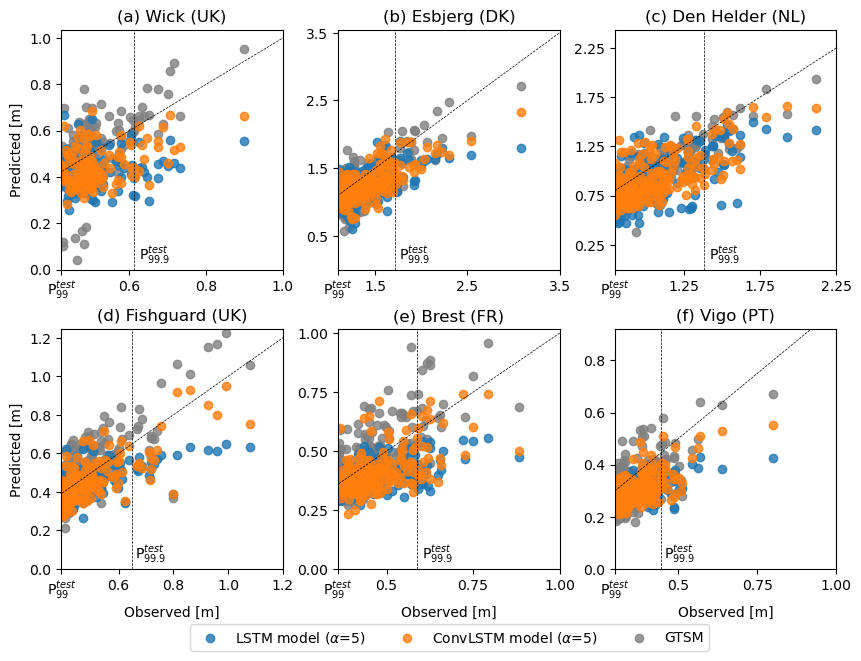

Mean ratio lstm to gtsm rmse_p99_test: 1.213311175683194
Mean ratio convlstm to gtsm rmse_p99_test: 1.071202699715677


In [63]:
#configure the plot
store_fig = 0
out_q = .99 #quantile to plot

convlstm_color = '#ff7f0e'
lstm_color = '#1f77b4'
gtsm_color='grey'

#make the plot
fig=plt.figure(figsize=(10,7)) 
gs = fig.add_gridspec(2,3)
gs.update(hspace=.25)
gs.update(wspace=.25)

selected_tgs = ['wick-wic-gbr-bodc.csv','esbjerg-esb-dnk-dmi.csv','den_helder-denhdr-nld-rws.csv', 'fishguard-fis-gbr-bodc.csv',  'brest-822a-fra-uhslc.csv','vigo-vigo-esp-ieo.csv']
selected_tgnames = ['Wick (UK)', 'Esbjerg (DK)','Den Helder (NL)','Fishguard (UK)','Brest (FR)', 'Vigo (PT)']

best_lstm_rmses_99 = []
best_convlstm_rmses_99 = []
gtsm_rmses_99 = []

best_lstm_rmses_999 = []
best_convlstm_rmses_999 = []
gtsm_rmses_999= []

for t,tg in enumerate(selected_tgs): #loop over locations
    #find highest ranked LSTM and ConvLSTM models (for alpha=5) in validation split (same as in Figure 4):
    lstm_rmse = lstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split='val').where(lstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    lstm_f1 = lstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split='val').where(lstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    #2: find highest combined ranked model
    best_ranked_lstm = np.nanargmin(rankdata(lstm_f1*-1,nan_policy='omit')+rankdata(lstm_rmse,nan_policy='omit'))
    best_ranked_lstm_it,best_ranked_lstm_i = np.unravel_index(best_ranked_lstm,
                                                          lstms.rmse_extremes.sel(quantile=out_q).sel(split='val').sel(tg=tg).shape)
  
    convlstm_rmse = convlstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split='val').where(convlstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    convlstm_f1 = convlstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split='val').where(convlstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    best_ranked_convlstm = np.nanargmin(rankdata(convlstm_f1*-1,nan_policy='omit')+rankdata(convlstm_rmse,nan_policy='omit'))
    best_ranked_convlstm_it,best_ranked_convlstm_i = np.unravel_index(best_ranked_convlstm,
                                                          convlstms.rmse_extremes.sel(quantile=out_q).sel(split='val').sel(tg=tg).shape)

    selected_lstm = lstms.sel(tg=tg).isel(it=best_ranked_lstm_it).isel(i=best_ranked_lstm_i)
    selected_convlstm = convlstms.sel(tg=tg).isel(it=best_ranked_convlstm_it).isel(i=best_ranked_convlstm_i)
    
    #generate subplot per location:
    ax = plt.subplot(gs[np.unravel_index(t,(2,3))]) 

    ax.scatter(selected_lstm.o.sel(split='test').where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q)),
               selected_lstm.yhat.sel(split='test'),label=r'LSTM model ($\alpha$=5)',alpha=.8,c=lstm_color,zorder=-1) #plot LSTM predictions
    
    ax.scatter(selected_lstm.o.sel(split='test').where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q)),
               selected_convlstm.yhat.sel(split='test').where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q)),label=r'ConvLSTM model ($\alpha$=5)',alpha=.8,c=convlstm_color,zorder=0) #plot ConvLSTM predictions
    
    ax.scatter(selected_lstm.o.sel(split='test').where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q)),
               codec.surge.sel(tg=tg).sel(split='test').where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q)),label='GTSM',alpha=.8,c=gtsm_color,zorder=-2) #plot GTSM predictions
    
    ax.plot([-5,5],[-5,5],linestyle='dashed',color='black',linewidth=.5,zorder=5) #1:1 line
    ax.axvline(x=np.nanpercentile(selected_lstm.o.sel(split='test'),99.9),color='black',linestyle='dashed',linewidth=.5,zorder=5) #some lines and annotations
    ax.text(1.02*np.nanpercentile(selected_lstm.o.sel(split='test'),99.9),np.nanmax(selected_lstm.o.sel(split='test'))*.05,'P$_{99.9}^{test}$',color='black')

    ax.set_title(['(a)','(b)','(c)','(d)','(e)','(f)'][t]+' '+selected_tgnames[t])
    ax.set_xlim([observed_thresholds.sel(tg=tg).sel(split='test').isel(quantile=2),np.nanmax(selected_lstm.o.sel(split='test'))*1.05])
    ax.set_ylim([0,np.nanmax(selected_lstm.o.sel(split='test'))*1.15])
  
    if t>2:
        ax.set_xlabel('Observed [m]')
    if t==0 or t==3:
        ax.set_ylabel('Predicted [m]')
    
    #set ticks depending on tide gauge:
    if t==0:
        ax.set_xticks([np.nanpercentile(selected_lstm.o.sel(split='test'),99),
                       0.6,0.8,1],['P$_{99}^{test}$','0.6','0.8','1.0'])
        ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1])
    
    elif t==1:
        ax.set_xticks([np.nanpercentile(selected_lstm.o.sel(split='test'),99),
                       1.5,2.5,3.5],['P$_{99}^{test}$','1.5','2.5','3.5'])
        ax.set_yticks([0.5,1.5,2.5,3.5])
    elif t==2:
        ax.set_xticks([np.nanpercentile(selected_lstm.o.sel(split='test'),99),
                       1.25,1.75,2.25],['P$_{99}^{test}$','1.25','1.75','2.25'])
        ax.set_yticks([.25,0.75,1.25,1.75,2.25])
    elif t==3:
        ax.set_xticks([np.nanpercentile(selected_lstm.o.sel(split='test'),99),
                       0.6,0.8,1,1.2],['P$_{99}^{test}$','0.6','0.8','1.0','1.2'])
        ax.set_yticks([0,0.2,0.4,0.6,0.8,1,1.2])
    elif t==4:
        ax.set_xticks([np.nanpercentile(selected_lstm.o.sel(split='test'),99),
                       .5,.75,1],['P$_{99}^{test}$','0.5','0.75','1.00'])
        ax.set_yticks([0,0.25,.5,.75,1])
    elif t==5:
        ax.set_xticks([np.nanpercentile(selected_lstm.o.sel(split='test'),99),
                       .5,.75,1],['P$_{99}^{test}$','0.5','0.75','1.00'])
        ax.set_yticks([0,0.2,.4,.6,.8])
    
    if t==0:
        ax.legend(bbox_to_anchor=(.55, -1.45), loc='upper left',ncol=3) #add legend once
    
    best_lstm_rmses_99.append(selected_lstm.sel(split='test').sel(quantile=out_q).rmse_extremes.values)
    best_convlstm_rmses_99.append(selected_convlstm.sel(split='test').sel(quantile=out_q).rmse_extremes.values)
    gtsm_rmses_99.append(codec.rmse_extremes.sel(tg=tg).isel(quantile=2).sel(split='test').values)
    
    #compute RMSE above 99:
    p99 = np.nanpercentile(selected_lstm.sel(split='test').o,99)
    where_ht_99 = selected_lstm.sel(split='test').o.where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q)) >= p99
    o_peaks = selected_lstm.sel(split='test').o[where_ht_99].values
    lstm_peaks = selected_lstm.sel(split='test').yhat[where_ht_99].values
    codec_peaks = codec.surge.sel(tg=tg).sel(split='test')[where_ht_99].values
    conv_peaks = selected_convlstm.sel(split='test').yhat[where_ht_99].values
    
    lstm_errs_99 = 100*(lstm_peaks - o_peaks)/o_peaks
    conv_errs_99 = 100*(conv_peaks - o_peaks)/o_peaks
    codec_errs_99 = 100*(codec_peaks-o_peaks)/o_peaks
    
    lstm_rmse_99 = np.sqrt(np.mean((lstm_peaks-o_peaks)**2))#/np.nanpercentile(lstms.sel(tg=tg).o.isel(it=best_ranked_lstm_it).sel(split='test').isel(i=best_ranked_lstm_i),99.9)
    convlstm_rmse_99 =np.sqrt(np.mean((conv_peaks-o_peaks)**2))#/np.nanpercentile(lstms.sel(tg=tg).o.isel(it=best_ranked_lstm_it).sel(split='test').isel(i=best_ranked_lstm_i),99.9)
    gtsm_rmse_99 =np.sqrt(np.mean((codec_peaks-o_peaks)**2))#/np.nanpercentile(lstms.sel(tg=tg).o.isel(it=best_ranked_lstm_it).sel(split='test').isel(i=best_ranked_lstm_i),99.9)
    
    #compute RMSE above 99.9:
    p999 = np.nanpercentile(selected_lstm.sel(split='test').o,99.9)
    where_ht_999 = selected_lstm.sel(split='test').o.where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q)) >= p999
    o_peaks = selected_lstm.sel(split='test').o[where_ht_999].values
    lstm_peaks = selected_lstm.sel(split='test').yhat[where_ht_999].values
    codec_peaks = codec.surge.sel(tg=tg).sel(split='test')[where_ht_999].values
    conv_peaks = selected_convlstm.sel(split='test').yhat[where_ht_999].values
    
    lstm_errs_999 = 100*(lstm_peaks - o_peaks)/o_peaks
    conv_errs_999 = 100*(conv_peaks - o_peaks)/o_peaks
    codec_errs_999 = 100*(codec_peaks-o_peaks)/o_peaks
    
    lstm_rmse_999 = np.sqrt(np.mean((lstm_peaks-o_peaks)**2))#/np.nanpercentile(lstms.sel(tg=tg).o.isel(it=best_ranked_lstm_it).sel(split='test').isel(i=best_ranked_lstm_i),99.9)
    convlstm_rmse_999 =np.sqrt(np.mean((conv_peaks-o_peaks)**2))#/np.nanpercentile(lstms.sel(tg=tg).o.isel(it=best_ranked_lstm_it).sel(split='test').isel(i=best_ranked_lstm_i),99.9)
    gtsm_rmse_999 =np.sqrt(np.mean((codec_peaks-o_peaks)**2))#/np.nanpercentile(lstms.sel(tg=tg).o.isel(it=best_ranked_lstm_it).sel(split='test').isel(i=best_ranked_lstm_i),99.9)

    best_lstm_rmses_999.append(lstm_rmse_999)
    best_convlstm_rmses_999.append(convlstm_rmse_999)
    gtsm_rmses_999.append(gtsm_rmse_999)
    
plt.show()
if store_fig:
    fig.savefig('../nhess_figures/sfig6_yhat_obs_test_scatter.jpg',format='jpg',dpi=300,bbox_inches='tight') #store figure

print('Mean ratio lstm to gtsm rmse_p99_test: '+str(np.mean(np.stack(best_lstm_rmses_99)/codec.sel(tg=selected_tgs).sel(split='test').rmse_extremes.sel(quantile=.99).values)))
print('Mean ratio convlstm to gtsm rmse_p99_test: '+str(np.mean(np.stack(best_convlstm_rmses_99)/codec.sel(tg=selected_tgs).sel(split='test').rmse_extremes.sel(quantile=.99).values)))

Plot manuscript Figure 5 - error distributions of fig C3:

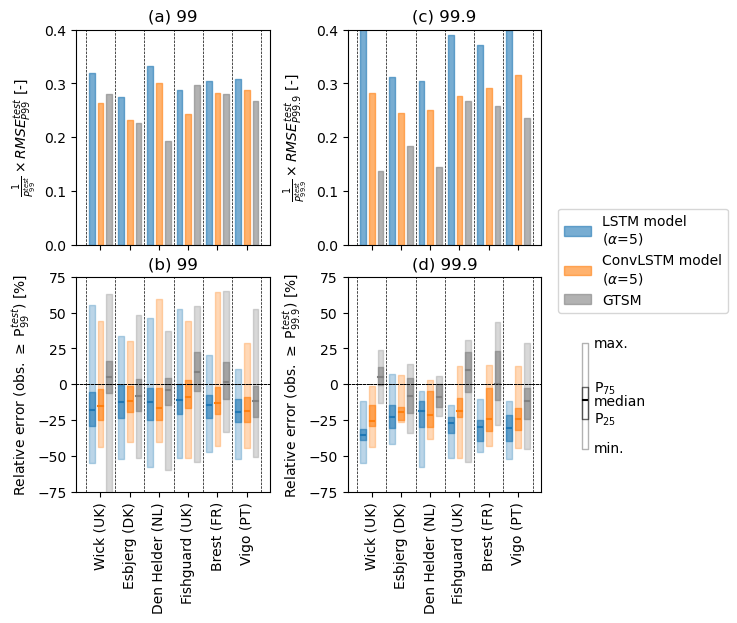

In [10]:
#configure the plot
store_fig = 0
out_q = .99 #quantile to plot

convlstm_color = '#ff7f0e'
lstm_color = '#1f77b4'
gtsm_color='grey'

#make the plot
fig=plt.figure(figsize=(6,6)) 
gs = fig.add_gridspec(2,2)
gs.update(hspace=.15)
gs.update(wspace=.4)

selected_tgs = ['wick-wic-gbr-bodc.csv','esbjerg-esb-dnk-dmi.csv','den_helder-denhdr-nld-rws.csv', 'fishguard-fis-gbr-bodc.csv',  'brest-822a-fra-uhslc.csv','vigo-vigo-esp-ieo.csv']
selected_tgnames = ['Wick (UK)', 'Esbjerg (DK)','Den Helder (NL)','Fishguard (UK)','Brest (FR)', 'Vigo (PT)']

best_lstm_rmses_99 = []
best_convlstm_rmses_99 = []
gtsm_rmses_99 = []

best_lstm_rmses_999 = []
best_convlstm_rmses_999 = []
gtsm_rmses_999= []

rmse_ax99 = plt.subplot(gs[0,0]) 
rmse_ax999 = plt.subplot(gs[0,1]) 

error_ax99 = plt.subplot(gs[1,0]) 
error_ax999 = plt.subplot(gs[1,1]) 

for t,tg in enumerate(selected_tgs): #loop over locations
    #find highest ranked LSTM and ConvLSTM models (for alpha=5) in validation split (same as in Figure 4):
    lstm_rmse = lstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split='val').where(lstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    lstm_f1 = lstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split='val').where(lstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    #2: find highest combined ranked model
    best_ranked_lstm = np.nanargmin(rankdata(lstm_f1*-1,nan_policy='omit')+rankdata(lstm_rmse,nan_policy='omit'))
    best_ranked_lstm_it,best_ranked_lstm_i = np.unravel_index(best_ranked_lstm,
                                                          lstms.rmse_extremes.sel(quantile=out_q).sel(split='val').sel(tg=tg).shape)
  
    convlstm_rmse = convlstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split='val').where(convlstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    convlstm_f1 = convlstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split='val').where(convlstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    best_ranked_convlstm = np.nanargmin(rankdata(convlstm_f1*-1,nan_policy='omit')+rankdata(convlstm_rmse,nan_policy='omit'))
    best_ranked_convlstm_it,best_ranked_convlstm_i = np.unravel_index(best_ranked_convlstm,
                                                          convlstms.rmse_extremes.sel(quantile=out_q).sel(split='val').sel(tg=tg).shape)

    selected_lstm = lstms.sel(tg=tg).isel(it=best_ranked_lstm_it).isel(i=best_ranked_lstm_i)
    selected_convlstm = convlstms.sel(tg=tg).isel(it=best_ranked_convlstm_it).isel(i=best_ranked_convlstm_i)
    
    best_lstm_rmses_99.append(selected_lstm.sel(split='test').sel(quantile=out_q).rmse_extremes.values)
    best_convlstm_rmses_99.append(selected_convlstm.sel(split='test').sel(quantile=out_q).rmse_extremes.values)
    gtsm_rmses_99.append(codec.rmse_extremes.sel(tg=tg).isel(quantile=2).sel(split='test').values)
    
    #compute RMSE above 99:
    p99 = np.nanpercentile(selected_lstm.sel(split='test').o,99)
    where_ht_99 = selected_lstm.sel(split='test').o.where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q)) >= p99
    o_peaks = selected_lstm.sel(split='test').o[where_ht_99].values
    lstm_peaks = selected_lstm.sel(split='test').yhat[where_ht_99].values
    codec_peaks = codec.surge.sel(tg=tg).sel(split='test')[where_ht_99].values
    conv_peaks = selected_convlstm.sel(split='test').yhat[where_ht_99].values
    
    lstm_errs_99 = 100*(lstm_peaks - o_peaks)/o_peaks
    conv_errs_99 = 100*(conv_peaks - o_peaks)/o_peaks
    codec_errs_99 = 100*(codec_peaks-o_peaks)/o_peaks
    
    lstm_rmse_99 = np.sqrt(np.mean((lstm_peaks-o_peaks)**2))#/np.nanpercentile(lstms.sel(tg=tg).o.isel(it=best_ranked_lstm_it).sel(split='test').isel(i=best_ranked_lstm_i),99.9)
    convlstm_rmse_99 =np.sqrt(np.mean((conv_peaks-o_peaks)**2))#/np.nanpercentile(lstms.sel(tg=tg).o.isel(it=best_ranked_lstm_it).sel(split='test').isel(i=best_ranked_lstm_i),99.9)
    gtsm_rmse_99 =np.sqrt(np.mean((codec_peaks-o_peaks)**2))#/np.nanpercentile(lstms.sel(tg=tg).o.isel(it=best_ranked_lstm_it).sel(split='test').isel(i=best_ranked_lstm_i),99.9)
    
    #compute RMSE above 99.9:
    p999 = np.nanpercentile(selected_lstm.sel(split='test').o,99.9)
    where_ht_999 = selected_lstm.sel(split='test').o.where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q)) >= p999
    o_peaks = selected_lstm.sel(split='test').o[where_ht_999].values
    lstm_peaks = selected_lstm.sel(split='test').yhat[where_ht_999].values
    codec_peaks = codec.surge.sel(tg=tg).sel(split='test')[where_ht_999].values
    conv_peaks = selected_convlstm.sel(split='test').yhat[where_ht_999].values
    
    lstm_errs_999 = 100*(lstm_peaks - o_peaks)/o_peaks
    conv_errs_999 = 100*(conv_peaks - o_peaks)/o_peaks
    codec_errs_999 = 100*(codec_peaks-o_peaks)/o_peaks
    
    lstm_rmse_999 = np.sqrt(np.mean((lstm_peaks-o_peaks)**2))#/np.nanpercentile(lstms.sel(tg=tg).o.isel(it=best_ranked_lstm_it).sel(split='test').isel(i=best_ranked_lstm_i),99.9)
    convlstm_rmse_999 =np.sqrt(np.mean((conv_peaks-o_peaks)**2))#/np.nanpercentile(lstms.sel(tg=tg).o.isel(it=best_ranked_lstm_it).sel(split='test').isel(i=best_ranked_lstm_i),99.9)
    gtsm_rmse_999 =np.sqrt(np.mean((codec_peaks-o_peaks)**2))#/np.nanpercentile(lstms.sel(tg=tg).o.isel(it=best_ranked_lstm_it).sel(split='test').isel(i=best_ranked_lstm_i),99.9)

    best_lstm_rmses_999.append(lstm_rmse_999)
    best_convlstm_rmses_999.append(convlstm_rmse_999)
    gtsm_rmses_999.append(gtsm_rmse_999)
    
    #a
    if t==0:
        rmse_ax99.axvline(x=-.2,color='black',linewidth=.5,linestyle='dashed')
    rmse_ax99.axvline(x=t+.8,color='black',linewidth=.5,linestyle='dashed')
    
    if t==0:
        rmse_ax99.fill_between([t-.1,t+.1],0,selected_lstm.sel(split='test').sel(quantile=out_q).rmse_extremes.values/observed_thresholds.sel(quantile=out_q).sel(tg=tg).sel(split='test').values,alpha=.6,color=lstm_color,label='LSTM')
    else:
        rmse_ax99.fill_between([t-.1,t+.1],0,selected_lstm.sel(split='test').sel(quantile=out_q).rmse_extremes.values/observed_thresholds.sel(quantile=out_q).sel(tg=tg).sel(split='test').values,alpha=.6,color=lstm_color)
    
    if t==0:
        rmse_ax99.fill_between([t-.1+.3,t+.1+.3],0,selected_convlstm.sel(split='test').sel(quantile=out_q).rmse_extremes.values/observed_thresholds.isel(quantile=2).sel(tg=tg).sel(split='test').values,alpha=.6,color=convlstm_color,label='ConvLSTM')
    else:
        rmse_ax99.fill_between([t-.1+.3,t+.1+.3],0,selected_convlstm.sel(split='test').sel(quantile=out_q).rmse_extremes.values/observed_thresholds.isel(quantile=2).sel(tg=tg).sel(split='test').values,alpha=.6,color=convlstm_color)
    
    if t==0:
        rmse_ax99.fill_between([t-.1+.6,t+.1+.6],0,codec.rmse_extremes.sel(tg=tg).isel(quantile=2).sel(split='test').values/observed_thresholds.isel(quantile=2).sel(tg=tg).sel(split='test').values,alpha=.6,color=gtsm_color,label='GTSM')
    else:
        rmse_ax99.fill_between([t-.1+.6,t+.1+.6],0,codec.rmse_extremes.sel(tg=tg).isel(quantile=2).sel(split='test').values/observed_thresholds.isel(quantile=2).sel(tg=tg).sel(split='test').values,alpha=.6,color=gtsm_color)

    #rmse_ax999.axhline(y=0,color='black',linestyle='dashed',linewidth=.5)
    rmse_ax99.set_ylabel(r'$\frac{{1}}{{P_{99}^{test}}} \times RMSE_{P99}^{test}$ [-]')
    rmse_ax99.set_xticks(np.arange(len(selected_tgs))+.3,[],rotation=90)
    rmse_ax99.set_title('(a) 99')
    rmse_ax99.set_ylim([0,.4])
    rmse_ax99.set_xlim([-.525,6.1])
    #b
    if t==0:
        rmse_ax999.axvline(x=-.2,color='black',linewidth=.5,linestyle='dashed')
    rmse_ax999.axvline(x=t+.8,color='black',linewidth=.5,linestyle='dashed')
    
    if t==0:
        rmse_ax999.fill_between([t-.1,t+.1],0,lstm_rmse_999/p999,alpha=.6,color=lstm_color,label='LSTM')
    else:
        rmse_ax999.fill_between([t-.1,t+.1],0,lstm_rmse_999/p999,alpha=.6,color=lstm_color)
    
    if t==0:
        rmse_ax999.fill_between([t-.1+.3,t+.1+.3],0,convlstm_rmse_999/p999,alpha=.6,color=convlstm_color,label='ConvLSTM')
    else:
        rmse_ax999.fill_between([t-.1+.3,t+.1+.3],0,convlstm_rmse_999/p999,alpha=.6,color=convlstm_color)
    
    if t==0:
        rmse_ax999.fill_between([t-.1+.6,t+.1+.6],0,gtsm_rmse_999/p999,alpha=.6,color=gtsm_color,label='GTSM')
    else:
        rmse_ax999.fill_between([t-.1+.6,t+.1+.6],0,gtsm_rmse_999/p999,alpha=.6,color=gtsm_color)

    #rmse_ax99.axhline(y=0,color='black',linestyle='dashed',linewidth=.5)
    rmse_ax999.set_ylabel(r'$\frac{{1}}{{P_{99.9}^{test}}} \times RMSE_{P99.9}^{test}$ [-]')
    rmse_ax999.set_xticks(np.arange(len(selected_tgs))+.3,[],rotation=90)
    rmse_ax999.set_title('(c) 99.9')
    rmse_ax999.set_ylim([0,.4])
    rmse_ax999.set_xlim([-.525,6.1])
    

    ############ plot error distributions
    #c
    if t==0:
        error_ax99.axvline(x=-.2,color='black',linewidth=.5,linestyle='dashed')
    error_ax99.axvline(x=t+.8,color='black',linewidth=.5,linestyle='dashed')
    
    error_ax99.fill_between([t-.1,t+.1],np.nanmin(lstm_errs_99),np.nanmax(lstm_errs_99),alpha=.3,color=lstm_color)
    if t==0:
        error_ax99.fill_between([t-.1,t+.1],np.nanpercentile(lstm_errs_99,25),np.nanpercentile(lstm_errs_99,75),alpha=.6,color=lstm_color,label='LSTM')
    else:
        error_ax99.fill_between([t-.1,t+.1],np.nanpercentile(lstm_errs_99,25),np.nanpercentile(lstm_errs_99,75),alpha=.6,color=lstm_color)
    error_ax99.plot([t-.075,t+.075],[np.median(lstm_errs_99),np.nanmedian(lstm_errs_99)],color=lstm_color)
    #ax.plot([t-.07,t+.1],[np.nanmin(lstm_errs_99),np.nanmin(lstm_errs_99)],color=lstm_color)
    #ax.plot([t-.07,t+.1],[np.nanmax(lstm_errs_99),np.nanmax(lstm_errs_99)],color=lstm_color)
    #ax.plot([t,t],[np.nanmin(lstm_errs_99),np.nanpercentile(lstm_errs_99,25)],color=lstm_color)
    #ax.plot([t,t],[np.nanmax(lstm_errs_99),np.nanpercentile(lstm_errs_99,75)],color=lstm_color)
    
    error_ax99.fill_between([t-.1+.3,t+.1+.3],np.nanmin(conv_errs_99),np.nanmax(conv_errs_99),alpha=.3,color=convlstm_color)
    if t==0:
        error_ax99.fill_between([t-.1+.3,t+.1+.3],np.nanpercentile(conv_errs_99,25),np.nanpercentile(conv_errs_99,75),alpha=.6,color=convlstm_color,label='ConvLSTM')
    else:
        error_ax99.fill_between([t-.1+.3,t+.1+.3],np.nanpercentile(conv_errs_99,25),np.nanpercentile(conv_errs_99,75),alpha=.6,color=convlstm_color)
    
    error_ax99.plot([t-.075+.3,t+.075+.3],[np.nanmedian(conv_errs_99),np.nanmedian(conv_errs_99)],color=convlstm_color)
    #ax.plot([t-.07+.3,t+.1+.3],[np.nanmin(conv_errs_99),np.nanmin(conv_errs_99)],color=convlstm_color)
    #ax.plot([t-.07+.3,t+.1+.3],[np.nanmax(conv_errs_99),np.nanmax(conv_errs_99)],color=convlstm_color)
    #ax.plot([t+.3,t+.3],[np.nanmin(conv_errs_99),np.nanpercentile(conv_errs_99,25)],color=convlstm_color)
    #ax.plot([t+.3,t+.3],[np.nanmax(conv_errs_99),np.nanpercentile(conv_errs_99,75)],color=convlstm_color)
    
    error_ax99.fill_between([t-.1+.6,t+.1+.6],np.nanmin(codec_errs_99),np.nanmax(codec_errs_99),alpha=.3,color=gtsm_color)
    if t==0:
        error_ax99.fill_between([t-.1+.6,t+.1+.6],np.nanpercentile(codec_errs_99,25),np.nanpercentile(codec_errs_99,75),alpha=.6,color=gtsm_color,label='GTSM')
    else:
        error_ax99.fill_between([t-.1+.6,t+.1+.6],np.nanpercentile(codec_errs_99,25),np.nanpercentile(codec_errs_99,75),alpha=.6,color=gtsm_color)
    
    error_ax99.plot([t-.075+.6,t+.075+.6],[np.nanmedian(codec_errs_99),np.nanmedian(codec_errs_99)],color=gtsm_color)
    #ax.plot([t-.07+.6,t+.1+.6],[np.nanmin(codec_errs_99),np.nanmin(codec_errs_99)],color=gtsm_color)
    #ax.plot([t-.07+.6,t+.1+.6],[np.nanmax(codec_errs_99),np.nanmax(codec_errs_99)],color=gtsm_color)
    #ax.plot([t+.6,t+.6],[np.nanmin(codec_errs_99),np.nanpercentile(codec_errs_99,25)],color=gtsm_color)
    #ax.plot([t+.6,t+.6],[np.nanmax(codec_errs_99),np.nanpercentile(codec_errs_99,75)],color=gtsm_color)
    
    error_ax99.axhline(y=0,color='black',linestyle='dashed',linewidth=.5)
    error_ax99.set_ylabel('Relative error (obs. $\geq$ P$_{99}^{test})$ [%]')
    error_ax99.set_xticks(np.arange(len(selected_tgs))+.3,selected_tgnames,rotation=90)
    error_ax99.set_title('(b) 99')
    error_ax99.set_yticks([-75,-50,-25,0,25,50,75])
    error_ax99.set_ylim([-75,75])
    error_ax99.set_xlim([-.525,6.1])
    #d
    if t==0:
        error_ax999.axvline(x=-.2,color='black',linewidth=.5,linestyle='dashed')
    error_ax999.axvline(x=t+.8,color='black',linewidth=.5,linestyle='dashed')
    
    error_ax999.fill_between([t-.1,t+.1],np.nanmin(lstm_errs_999),np.nanmax(lstm_errs_999),alpha=.3,color=lstm_color)
    if t==0:
        error_ax999.fill_between([t-.1,t+.1],np.nanpercentile(lstm_errs_999,25),np.nanpercentile(lstm_errs_999,75),alpha=.6,color=lstm_color,label='LSTM model''\n'r'($\alpha$=5)')
    else:
        error_ax999.fill_between([t-.1,t+.1],np.nanpercentile(lstm_errs_999,25),np.nanpercentile(lstm_errs_999,75),alpha=.6,color=lstm_color)
    error_ax999.plot([t-.075,t+.075],[np.median(lstm_errs_999),np.nanmedian(lstm_errs_999)],color=lstm_color)
    #ax.plot([t-.07,t+.1],[np.nanmin(lstm_errs_999),np.nanmin(lstm_errs_999)],color=lstm_color)
    #ax.plot([t-.07,t+.1],[np.nanmax(lstm_errs_999),np.nanmax(lstm_errs_999)],color=lstm_color)
    #ax.plot([t,t],[np.nanmin(lstm_errs_999),np.nanpercentile(lstm_errs_999,25)],color=lstm_color)
    #ax.plot([t,t],[np.nanmax(lstm_errs_999),np.nanpercentile(lstm_errs_999,75)],color=lstm_color)
    
    error_ax999.fill_between([t-.1+.3,t+.1+.3],np.nanmin(conv_errs_999),np.nanmax(conv_errs_999),alpha=.3,color=convlstm_color)
    if t==0:
        error_ax999.fill_between([t-.1+.3,t+.1+.3],np.nanpercentile(conv_errs_999,25),np.nanpercentile(conv_errs_999,75),alpha=.6,color=convlstm_color,label='ConvLSTM model''\n'r'($\alpha$=5)')
    else:
        error_ax999.fill_between([t-.1+.3,t+.1+.3],np.nanpercentile(conv_errs_999,25),np.nanpercentile(conv_errs_999,75),alpha=.6,color=convlstm_color)
    
    error_ax999.plot([t-.075+.3,t+.075+.3],[np.nanmedian(conv_errs_999),np.nanmedian(conv_errs_999)],color=convlstm_color)
    #ax.plot([t-.07+.3,t+.1+.3],[np.nanmin(conv_errs_999),np.nanmin(conv_errs_999)],color=convlstm_color)
    #ax.plot([t-.07+.3,t+.1+.3],[np.nanmax(conv_errs_999),np.nanmax(conv_errs_999)],color=convlstm_color)
    #ax.plot([t+.3,t+.3],[np.nanmin(conv_errs_999),np.nanpercentile(conv_errs_999,25)],color=convlstm_color)
    #ax.plot([t+.3,t+.3],[np.nanmax(conv_errs_999),np.nanpercentile(conv_errs_999,75)],color=convlstm_color)
    
    error_ax999.fill_between([t-.1+.6,t+.1+.6],np.nanmin(codec_errs_999),np.nanmax(codec_errs_999),alpha=.3,color=gtsm_color)
    if t==0:
        error_ax999.fill_between([t-.1+.6,t+.1+.6],np.nanpercentile(codec_errs_999,25),np.nanpercentile(codec_errs_999,75),alpha=.6,color=gtsm_color,label='GTSM')
    else:
        error_ax999.fill_between([t-.1+.6,t+.1+.6],np.nanpercentile(codec_errs_999,25),np.nanpercentile(codec_errs_999,75),alpha=.6,color=gtsm_color)
    
    error_ax999.plot([t-.075+.6,t+.075+.6],[np.nanmedian(codec_errs_999),np.nanmedian(codec_errs_999)],color=gtsm_color)
    
    #legend
    if t==5:
        error_ax999.fill_between([7-.1+.6,7+.1+.6],.2+np.nanmin(codec_errs_999),.2+np.nanmax(codec_errs_999),alpha=.3,color='white',edgecolor='black',clip_on=False)
        error_ax999.fill_between([7-.1+.6,7+.1+.6],.2+np.nanpercentile(codec_errs_999,25),.2+np.nanpercentile(codec_errs_999,75),alpha=.6,color='white',edgecolor='black',clip_on=False)
        error_ax999.plot([7-.075+.6,7+.075+.6],[.2+np.nanmedian(codec_errs_999),.2+np.nanmedian(codec_errs_999)],color='black',clip_on=False)
        error_ax999.text(7.9,.2+np.nanmedian(codec_errs_999)*1.3,'median',color='black',clip_on=False)
        error_ax999.text(7.9,.2+np.nanpercentile(codec_errs_999,25)*1.1,'P$_{25}$',color='black',clip_on=False)
        error_ax999.text(7.9,.2+np.nanpercentile(codec_errs_999,75)*2.2,'P$_{75}$',color='black',clip_on=False)
        error_ax999.text(7.9,.2+np.nanmax(codec_errs_999)*.9,'max.',color='black',clip_on=False)
        error_ax999.text(7.9,.2+np.nanmin(codec_errs_999)*1.05,'min.',color='black',clip_on=False)
    #ax.plot([t-.07+.6,t+.1+.6],[np.nanmin(codec_errs_999),np.nanmin(codec_errs_999)],color=gtsm_color)
    #ax.plot([t-.07+.6,t+.1+.6],[np.nanmax(codec_errs_999),np.nanmax(codec_errs_999)],color=gtsm_color)
    #ax.plot([t+.6,t+.6],[np.nanmin(codec_errs_999),np.nanpercentile(codec_errs_999,25)],color=gtsm_color)
    #ax.plot([t+.6,t+.6],[np.nanmax(codec_errs_999),np.nanpercentile(codec_errs_999,75)],color=gtsm_color)
    
    error_ax999.axhline(y=0,color='black',linestyle='dashed',linewidth=.5)
    error_ax999.set_ylabel('Relative error (obs. $\geq$ P$_{99.9}^{test})$ [%]')
    error_ax999.set_xticks(np.arange(len(selected_tgs))+.3,selected_tgnames,rotation=90)
    error_ax999.set_title('(d) 99.9')
    error_ax999.set_yticks([-75,-50,-25,0,25,50,75])
    error_ax999.set_ylim([-75,75])
    error_ax999.set_xlim([-.525,6.1])
    error_ax999.legend(bbox_to_anchor=(1.05, 1.35), loc='upper left',ncol=1) #add legend once

    
plt.show()
if store_fig:
    fig.savefig('../nhess_figures/fig5_test_err_dists.pdf',format='pdf',dpi=300,bbox_inches='tight') #store figure

In [25]:
np.mean(np.array(best_convlstm_rmses_999) - np.array(gtsm_rmses_999))

0.06710722169485014

In [55]:
np.stack(best_lstm_rmses_99)/gtsm_rmses_99

array([1.13936632, 1.20816229, 1.72148517, 0.97406126, 1.08173902])

In [56]:
np.stack(best_lstm_rmses_999)/gtsm_rmses_999

array([2.92786916, 1.69094848, 2.11673018, 1.46420841, 1.43660871])

In [59]:
np.stack(best_convlstm_rmses_99)/gtsm_rmses_99

array([0.94157731, 1.02421041, 1.55608864, 0.81912157, 1.00718741])

In [60]:
(np.stack(best_convlstm_rmses_999)/gtsm_rmses_999)/(np.stack(best_convlstm_rmses_99)/gtsm_rmses_99)

array([2.17825173, 1.2959104 , 1.12122614, 1.26765927, 1.11854112])

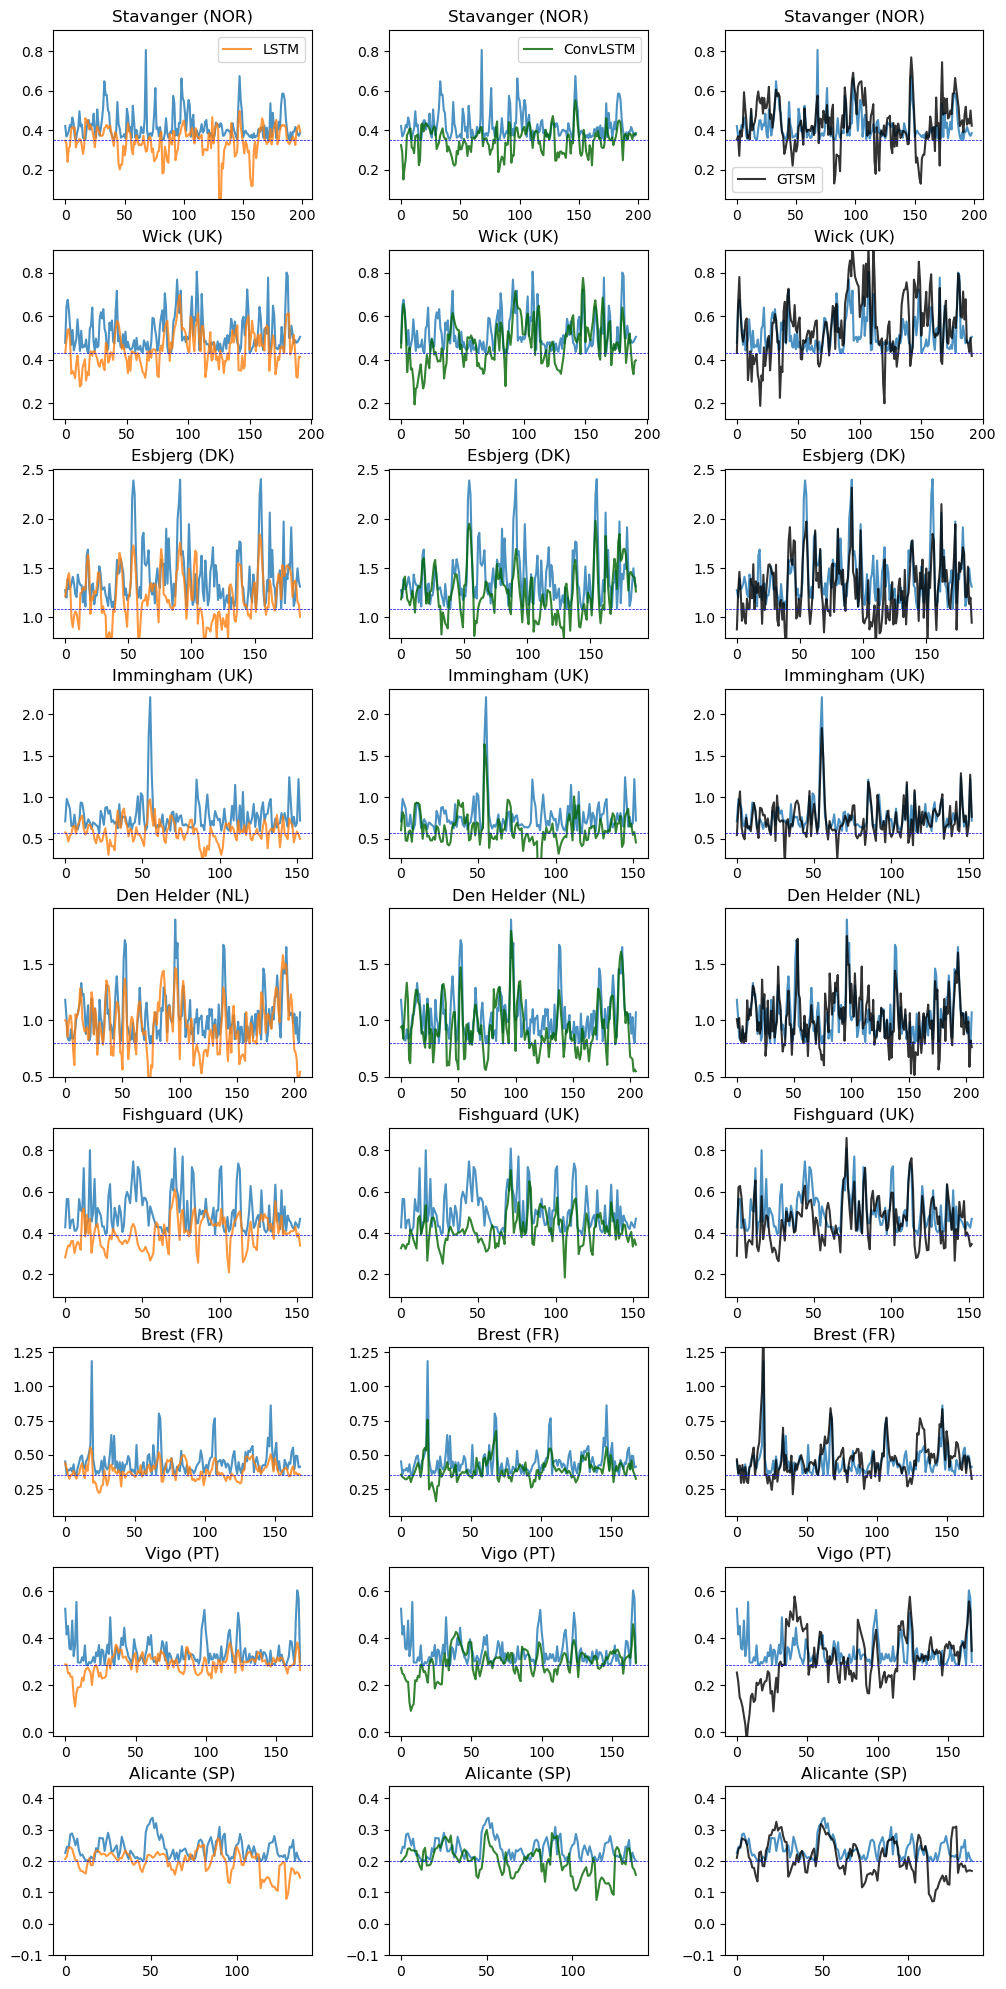

In [98]:
#"time" series for val-split
out_split = 'val' #split to plot
out_q = .99 #quantile to plot

fig=plt.figure(figsize=(12,25)) 
gs = fig.add_gridspec(9,3)
gs.update(hspace=.3)
gs.update(wspace=.3)

for t,tg in enumerate(tgs): #loop over locations
    #find highest ranked LSTM and ConvLSTM models (for alpha=5) in validation split (same as in Figure 4):
    lstm_rmse = lstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split='val').where(lstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    lstm_f1 = lstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split='val').where(lstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    #2: find highest combined ranked model
    best_ranked_lstm = np.nanargmin(rankdata(lstm_f1*-1,nan_policy='omit')+rankdata(lstm_rmse,nan_policy='omit'))
    best_ranked_lstm_it,best_ranked_lstm_i = np.unravel_index(best_ranked_lstm,
                                                          lstms.rmse_extremes.sel(quantile=out_q).sel(split='val').sel(tg=tg).shape)
  
    convlstm_rmse = convlstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split='val').where(convlstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    convlstm_f1 = convlstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split='val').where(convlstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    best_ranked_convlstm = np.nanargmin(rankdata(convlstm_f1*-1,nan_policy='omit')+rankdata(convlstm_rmse,nan_policy='omit'))
    best_ranked_convlstm_it,best_ranked_convlstm_i = np.unravel_index(best_ranked_convlstm,
                                                          convlstms.rmse_extremes.sel(quantile=out_q).sel(split='val').sel(tg=tg).shape)

    selected_lstm = lstms.sel(tg=tg).isel(it=best_ranked_lstm_it).isel(i=best_ranked_lstm_i)
    selected_convlstm = convlstms.sel(tg=tg).isel(it=best_ranked_convlstm_it).isel(i=best_ranked_convlstm_i)

    ax = plt.subplot(gs[t,0])
    ax.plot(selected_lstm.o.sel(split='val').where(where_observed_peaks.sel(tg=tg,split='val',quantile=out_q),drop=True).values,alpha=.8)
    ax.plot(selected_lstm.yhat.sel(split='val').where(where_observed_peaks.sel(tg=tg,split='val',quantile=out_q),drop=True).values,label='LSTM',alpha=.8)
    ax.axhline(y=observed_thresholds.sel(tg=tg).sel(split='val').isel(quantile=-2),color='blue',linestyle='dashed',linewidth=.5)
    ax.set_title(tgnames[t])
    ax.set_ylim([observed_thresholds.sel(tg=tg).sel(split='val').isel(quantile=-2)-.3, 
                 np.nanmax(selected_lstm.o.sel(split='val'))+.1])
    if t==0:
        ax.legend()
    
    ax = plt.subplot(gs[t,1])
    ax.plot(selected_convlstm.o.sel(split='val').where(where_observed_peaks.sel(tg=tg,split='val',quantile=out_q),drop=True).values,alpha=.8)
    ax.plot(selected_convlstm.yhat.sel(split='val').where(where_observed_peaks.sel(tg=tg,split='val',quantile=out_q),drop=True).values,label='ConvLSTM',alpha=.8,color='darkgreen')
    ax.axhline(y=observed_thresholds.sel(tg=tg).sel(split='val').isel(quantile=-2),color='blue',linestyle='dashed',linewidth=.5)
    ax.set_title(tgnames[t])
    ax.set_ylim([observed_thresholds.sel(tg=tg).sel(split='val').isel(quantile=-2)-.3, 
                 np.nanmax(selected_lstm.o.sel(split='val'))+.1])
    if t==0:
        ax.legend()
    
    ax = plt.subplot(gs[t,2])
    ax.plot(selected_lstm.o.sel(split='val').where(where_observed_peaks.sel(tg=tg,split='val',quantile=out_q),drop=True).values,alpha=.8)
    ax.plot(codec.surge.sel(tg=tg).sel(split='val').where(where_observed_peaks.sel(tg=tg,split='val',quantile=out_q),drop=True).values,label='GTSM',alpha=.8,color='black')
    ax.axhline(y=observed_thresholds.sel(tg=tg).sel(split='val').isel(quantile=-2),color='blue',linestyle='dashed',linewidth=.5)
    ax.set_title(tgnames[t])
    ax.set_ylim([observed_thresholds.sel(tg=tg).sel(split='val').isel(quantile=-2)-.3, 
                 np.nanmax(selected_lstm.o.sel(split='val'))+.1])
    
    if t==0:
        ax.legend()

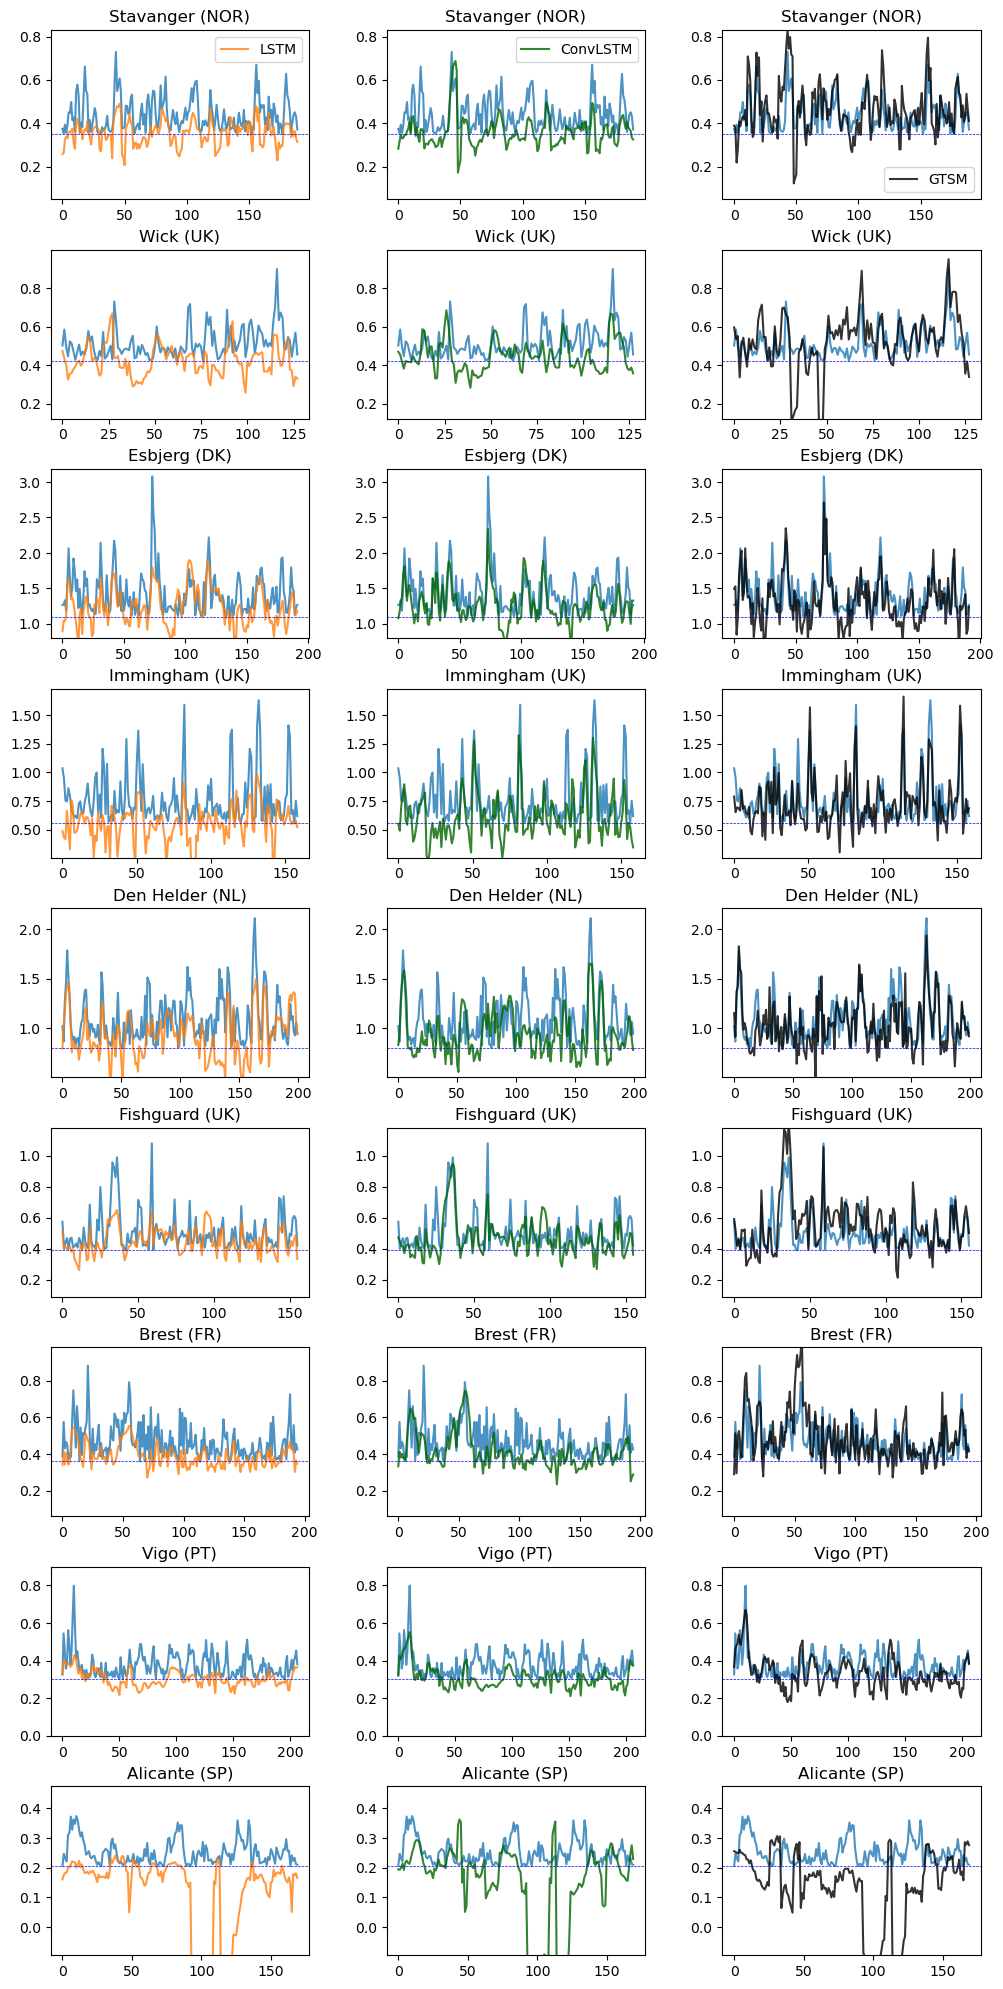

In [140]:
#"time" series for val-split
out_split = 'val' #split to plot
out_q = .99 #quantile to plot

fig=plt.figure(figsize=(12,25)) 
gs = fig.add_gridspec(9,3)
gs.update(hspace=.3)
gs.update(wspace=.3)

for t,tg in enumerate(tgs): #loop over locations
    #find highest ranked LSTM and ConvLSTM models (for alpha=5) in validation split (same as in Figure 4):
    lstm_rmse = lstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split='val').where(lstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    lstm_f1 = lstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split='val').where(lstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    #2: find highest combined ranked model
    best_ranked_lstm = np.nanargmin(rankdata(lstm_f1*-1,nan_policy='omit')+rankdata(lstm_rmse,nan_policy='omit'))
    best_ranked_lstm_it,best_ranked_lstm_i = np.unravel_index(best_ranked_lstm,
                                                          lstms.rmse_extremes.sel(quantile=out_q).sel(split='val').sel(tg=tg).shape)
  
    convlstm_rmse = convlstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split='val').where(convlstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    convlstm_f1 = convlstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split='val').where(convlstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    best_ranked_convlstm = np.nanargmin(rankdata(convlstm_f1*-1,nan_policy='omit')+rankdata(convlstm_rmse,nan_policy='omit'))
    best_ranked_convlstm_it,best_ranked_convlstm_i = np.unravel_index(best_ranked_convlstm,
                                                          convlstms.rmse_extremes.sel(quantile=out_q).sel(split='val').sel(tg=tg).shape)

    selected_lstm = lstms.sel(tg=tg).isel(it=best_ranked_lstm_it).isel(i=best_ranked_lstm_i)
    selected_convlstm = convlstms.sel(tg=tg).isel(it=best_ranked_convlstm_it).isel(i=best_ranked_convlstm_i)

    ax = plt.subplot(gs[t,0])
    ax.plot(selected_lstm.o.sel(split='test').where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q),drop=True).values,alpha=.8)
    ax.plot(selected_lstm.yhat.sel(split='test').where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q),drop=True).values,label='LSTM',alpha=.8)
    ax.axhline(y=observed_thresholds.sel(tg=tg).sel(split='test').isel(quantile=-2),color='blue',linestyle='dashed',linewidth=.5)
    ax.set_title(tgnames[t])
    ax.set_ylim([observed_thresholds.sel(tg=tg).sel(split='test').isel(quantile=-2)-.3, 
                 np.nanmax(selected_lstm.o.sel(split='test'))+.1])
    if t==0:
        ax.legend()
    
    ax = plt.subplot(gs[t,1])
    ax.plot(selected_convlstm.o.sel(split='test').where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q),drop=True).values,alpha=.8)
    ax.plot(selected_convlstm.yhat.sel(split='test').where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q),drop=True).values,label='ConvLSTM',alpha=.8,color='darkgreen')
    ax.axhline(y=observed_thresholds.sel(tg=tg).sel(split='test').isel(quantile=-2),color='blue',linestyle='dashed',linewidth=.5)
    ax.set_title(tgnames[t])
    ax.set_ylim([observed_thresholds.sel(tg=tg).sel(split='test').isel(quantile=-2)-.3, 
                 np.nanmax(selected_lstm.o.sel(split='test'))+.1])
    if t==0:
        ax.legend()
    
    ax = plt.subplot(gs[t,2])
    ax.plot(selected_lstm.o.sel(split='test').where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q),drop=True).values,alpha=.8)
    ax.plot(codec.surge.sel(tg=tg).sel(split='test').where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q),drop=True).values,label='GTSM',alpha=.8,color='black')
    ax.axhline(y=observed_thresholds.sel(tg=tg).sel(split='test').isel(quantile=-2),color='blue',linestyle='dashed',linewidth=.5)
    ax.set_title(tgnames[t])
    ax.set_ylim([observed_thresholds.sel(tg=tg).sel(split='test').isel(quantile=-2)-.3, 
                 np.nanmax(selected_lstm.o.sel(split='test'))+.1])
    
    if t==0:
        ax.legend()


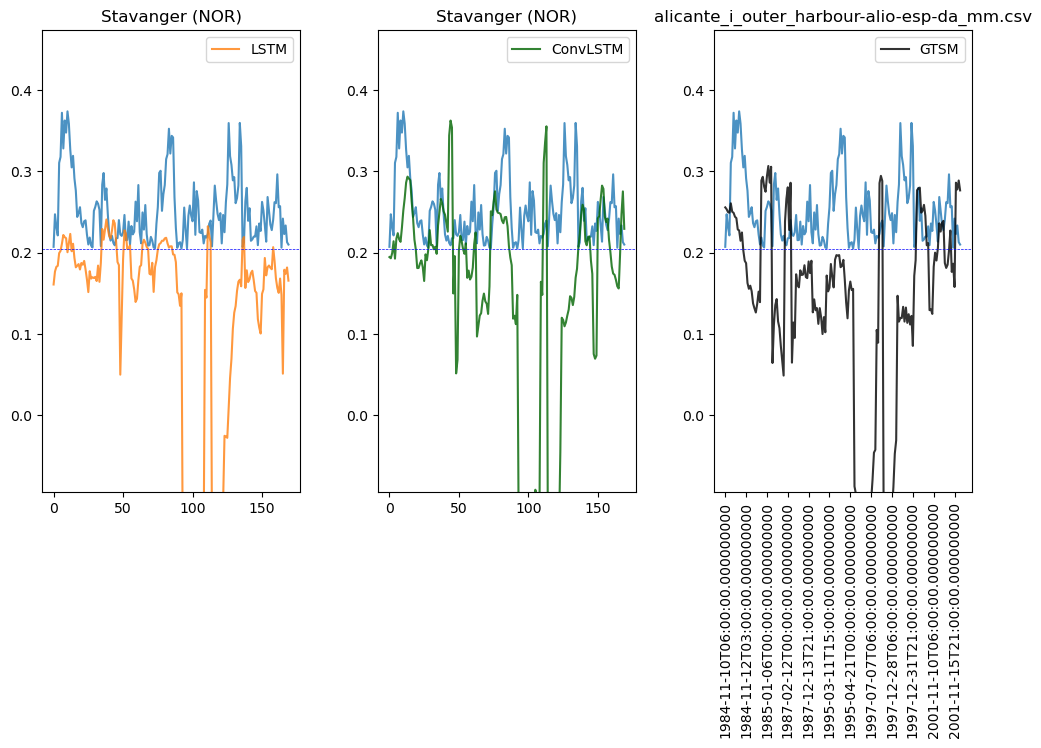

In [99]:
#"time" series for val-split
out_split = 'val' #split to plot
out_q = .99 #quantile to plot

fig=plt.figure(figsize=(12,6)) 
gs = fig.add_gridspec(1,3)
gs.update(hspace=.3)
gs.update(wspace=.3)

for t,tg in enumerate(['alicante_i_outer_harbour-alio-esp-da_mm.csv']): #loop over locations
    #find highest ranked LSTM and ConvLSTM models (for alpha=5) in validation split (same as in Figure 4):
    lstm_rmse = lstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split='val').where(lstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    lstm_f1 = lstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split='val').where(lstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    #2: find highest combined ranked model
    best_ranked_lstm = np.nanargmin(rankdata(lstm_f1*-1,nan_policy='omit')+rankdata(lstm_rmse,nan_policy='omit'))
    best_ranked_lstm_it,best_ranked_lstm_i = np.unravel_index(best_ranked_lstm,
                                                          lstms.rmse_extremes.sel(quantile=out_q).sel(split='val').sel(tg=tg).shape)
  
    convlstm_rmse = convlstms.sel(tg=tg).rmse_extremes.sel(quantile=out_q).sel(split='val').where(convlstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    convlstm_f1 = convlstms.sel(tg=tg).f1.sel(quantile=out_q).sel(split='val').where(convlstms.sel(tg=tg).sel(split='val').hyperparameters.sel(p='dl_alpha')==5).values.flatten()
    best_ranked_convlstm = np.nanargmin(rankdata(convlstm_f1*-1,nan_policy='omit')+rankdata(convlstm_rmse,nan_policy='omit'))
    best_ranked_convlstm_it,best_ranked_convlstm_i = np.unravel_index(best_ranked_convlstm,
                                                          convlstms.rmse_extremes.sel(quantile=out_q).sel(split='val').sel(tg=tg).shape)

    selected_lstm = lstms.sel(tg=tg).isel(it=best_ranked_lstm_it).isel(i=best_ranked_lstm_i)
    selected_convlstm = convlstms.sel(tg=tg).isel(it=best_ranked_convlstm_it).isel(i=best_ranked_convlstm_i)

    ax = plt.subplot(gs[t,0])
    ax.plot(selected_lstm.o.sel(split='test').where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q),drop=True).values,alpha=.8)
    ax.plot(selected_lstm.yhat.sel(split='test').where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q),drop=True).values,label='LSTM',alpha=.8)
    ax.axhline(y=observed_thresholds.sel(tg=tg).sel(split='test').isel(quantile=-2),color='blue',linestyle='dashed',linewidth=.5)
    ax.set_title(tgnames[t])
    ax.set_ylim([observed_thresholds.sel(tg=tg).sel(split='test').isel(quantile=-2)-.3, 
                 np.nanmax(selected_lstm.o.sel(split='test'))+.1])
    if t==0:
        ax.legend()
    
    ax = plt.subplot(gs[t,1])
    ax.plot(selected_convlstm.o.sel(split='test').where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q),drop=True).values,alpha=.8)
    ax.plot(selected_convlstm.yhat.sel(split='test').where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q),drop=True).values,label='ConvLSTM',alpha=.8,color='darkgreen')
    ax.axhline(y=observed_thresholds.sel(tg=tg).sel(split='test').isel(quantile=-2),color='blue',linestyle='dashed',linewidth=.5)
    ax.set_title(tgnames[t])
    ax.set_ylim([observed_thresholds.sel(tg=tg).sel(split='test').isel(quantile=-2)-.3, 
                 np.nanmax(selected_lstm.o.sel(split='test'))+.1])
    if t==0:
        ax.legend()
    
    ax = plt.subplot(gs[t,2])
    ax.plot(selected_lstm.o.sel(split='test').where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q),drop=True).values,alpha=.8)
    ax.plot(codec.surge.sel(tg=tg).sel(split='test').where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q),drop=True).values,label='GTSM',alpha=.8,color='black')
    ax.axhline(y=observed_thresholds.sel(tg=tg).sel(split='test').isel(quantile=-2),color='blue',linestyle='dashed',linewidth=.5)
    ax.set_title(tg)
    ax.set_ylim([observed_thresholds.sel(tg=tg).sel(split='test').isel(quantile=-2)-.3, 
                 np.nanmax(selected_lstm.o.sel(split='test'))+.1])
    
   
    timing = lstms.time.where(where_observed_peaks.sel(tg=tg,split='test',quantile=out_q),drop=True)
    ax.set_xticks(np.arange(len(timing))[0:-1:15],timing.values[0:-1:15],rotation=90)
 
    if t==0:
        ax.legend()


Plot some loss curves:

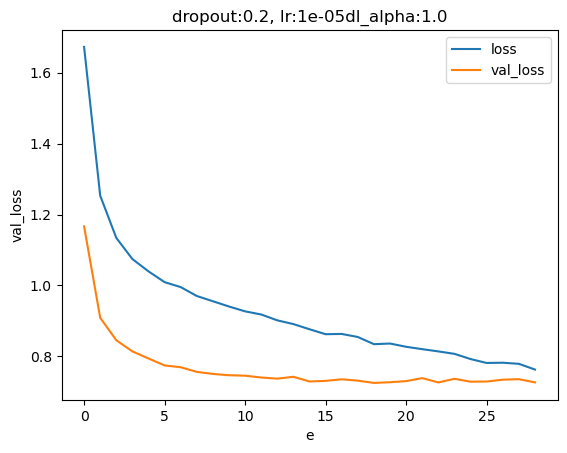

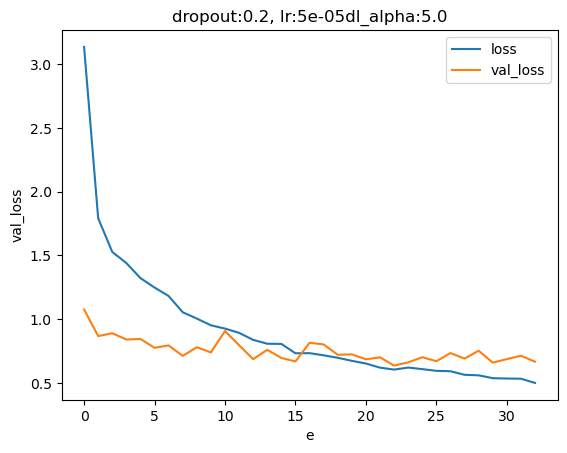

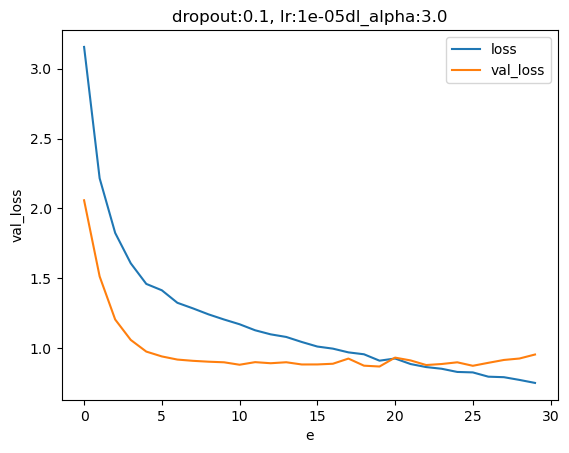

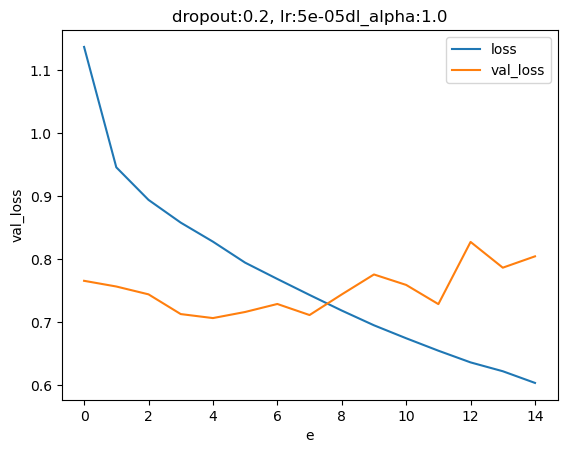

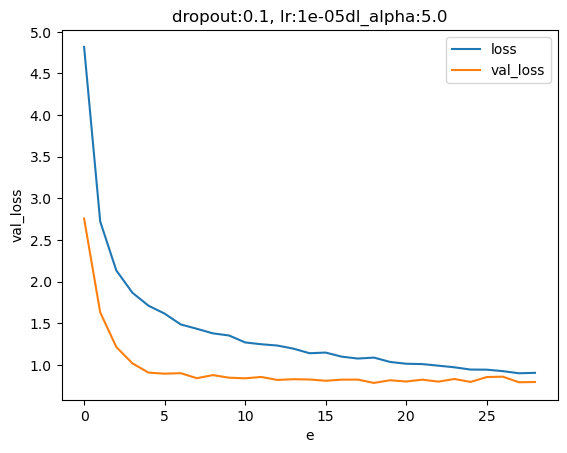

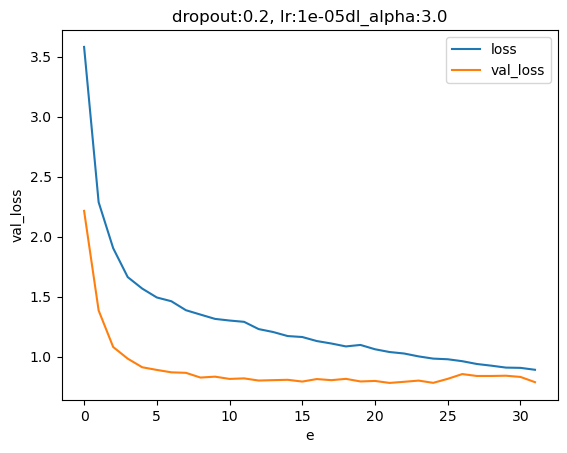

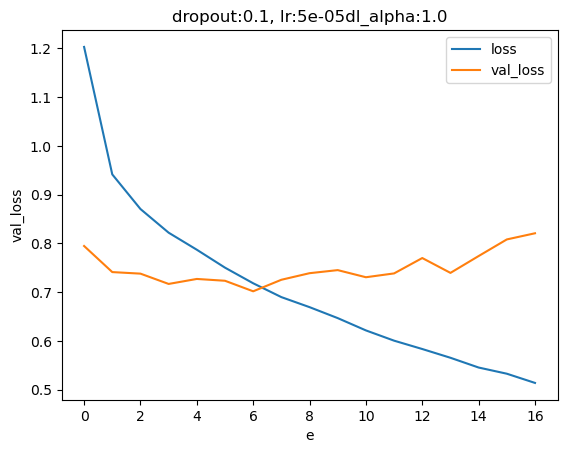

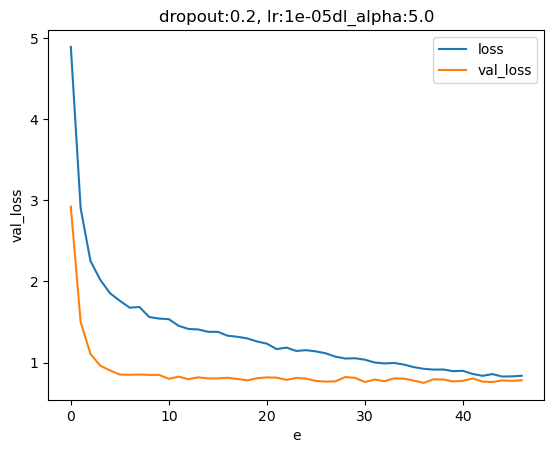

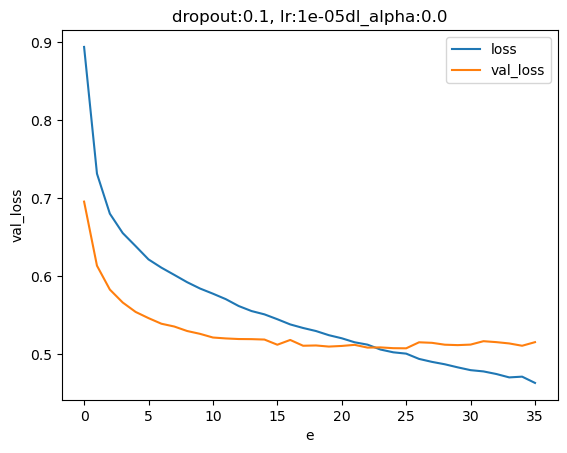

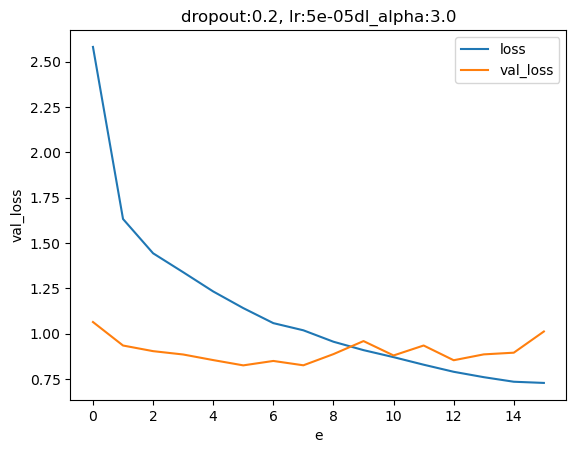

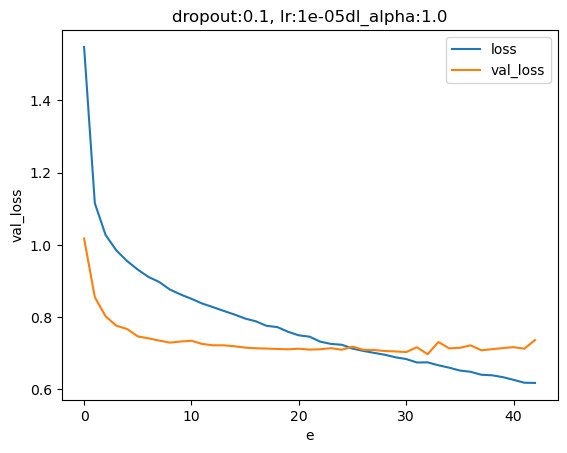

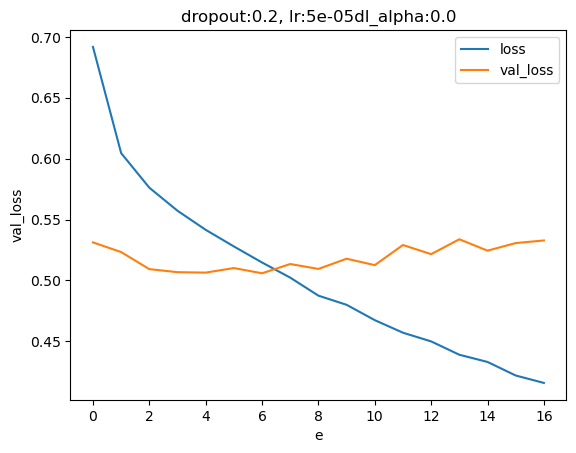

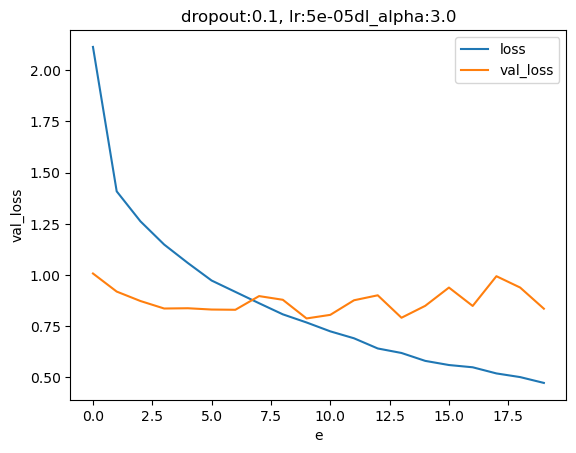

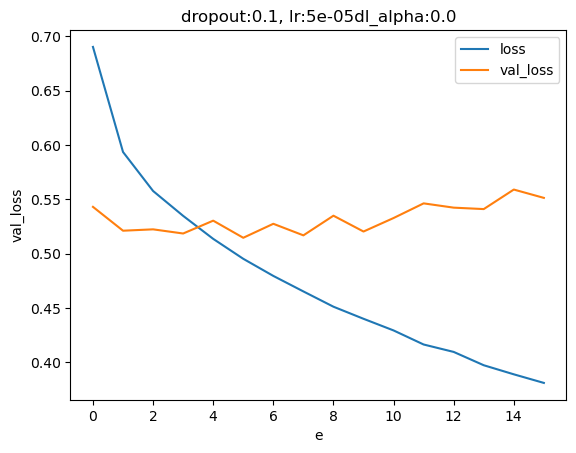

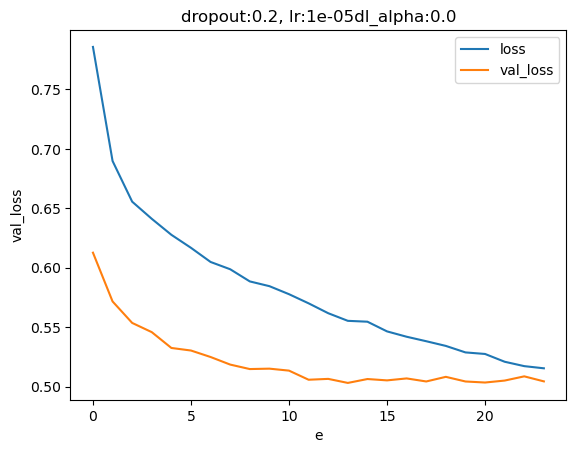

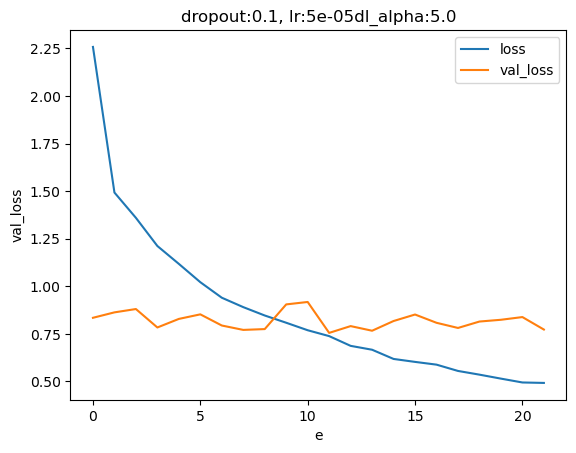

In [206]:

tgs        = ['stavanger-svg-nor-nhs.csv','wick-wic-gbr-bodc.csv','esbjerg-esb-dnk-dmi.csv','immingham-imm-gbr-bodc.csv','den_helder-denhdr-nld-rws.csv',
              'fishguard-fis-gbr-bodc.csv',  'brest-822a-fra-uhslc.csv', 'vigo-vigo-esp-ieo.csv',  'alicante_i_outer_harbour-alio-esp-da_mm.csv']
for i in np.arange(24):
    if np.isfinite(lstms.hyperparameters.isel(it=0,i=i,split=0).sel(tg=tg).sel(p='lr').values):
        plt.figure()
        lstms.sel(tg='alicante_i_outer_harbour-alio-esp-da_mm.csv').loss.isel(it=0).isel(i=i).sel(split='test').plot(label='loss')
        lstms.sel(tg='alicante_i_outer_harbour-alio-esp-da_mm.csv').val_loss.isel(it=0).isel(i=i).sel(split='test').plot(label='val_loss')
        plt.title('dropout:'+str(lstms.hyperparameters.isel(it=0,i=i,split=0).sel(tg=tg).sel(p='dropout').values)+', lr:'+str(lstms.hyperparameters.isel(it=0,i=i,split=0).sel(tg=tg).sel(p='lr').values)+'dl_alpha:'+str(lstms.hyperparameters.isel(it=0,i=i,split=0).sel(tg=tg).sel(p='dl_alpha').values))
        plt.legend()